In [1]:
from scipy.stats import truncnorm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, e
import scipy.stats as stats
import random

# The Data

## Normal

In [2]:
def get_truncated_normal(upp, mean=0, sd=1, low=0):
    return truncnorm((low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

In [3]:
def normal_me(d, mean, std, start, n):
    #get_truncated_normal(d, mean, std, start)
    gen = get_truncated_normal(d, mean, std, start)
    data = gen.rvs(n).astype(int)

    return data

[2 1 2 ... 1 3 1]
1    358498
2    356967
3    142850
0    141685
Name: count, dtype: int64


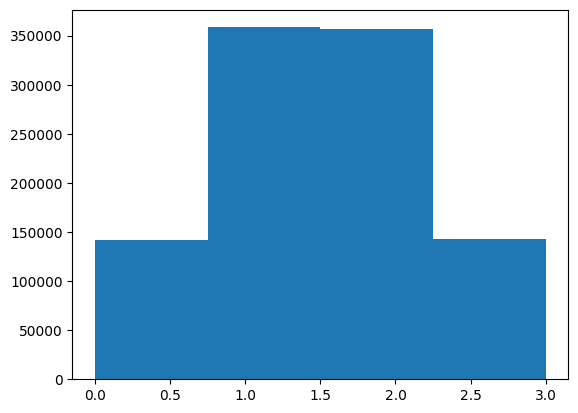

In [4]:
data = normal_me(4, 2, 1, 0, 10**6)
plt.hist(data, bins=4)
print(data)
print(pd.Series(data).value_counts())

## Zipf

In [5]:
def zipf_me(a, n, d):
    x = np.arange(1, d+1)
    
    weights = x ** (-a)
    weights /= weights.sum()
    bounded_zipf = stats.rv_discrete(name='bounded_zipf', values=(x, weights))
    
    sample = bounded_zipf.rvs(size=n)

    return sample

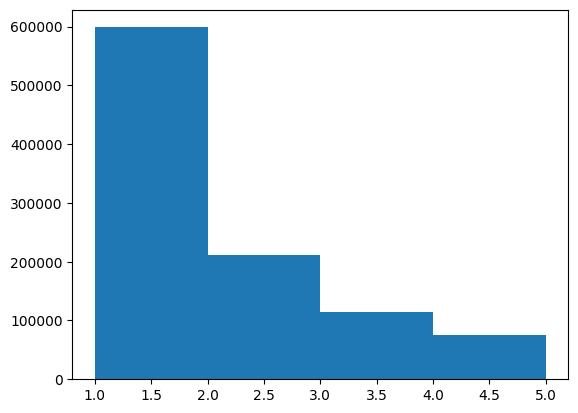

[2 1 4 ... 1 2 1]


In [6]:
data = zipf_me(1.5, 10**6, 4)
plt.hist(data, bins=np.arange(1, 4+2))
plt.show()
print(data)

# Algorithms

## Count query

In [7]:
def count_query(column, lower_b, upper_b):
    return ( column[((column >= lower_b) & (column <= upper_b))] ).value_counts().sort_index()

## DP

### Laplace mechanism

In [8]:
def laplace_mech(answer, sensitivity, epsilon):
    return answer + np.random.laplace(loc=0, scale=sensitivity / epsilon)

In [9]:
def noisy_count_query(data, attribute, lower_b, upper_b, epsilon):
    sensitivity = 1
    true_answer = count_query(data[attribute], lower_b, upper_b)
    noisy_answer = laplace_mech(true_answer, sensitivity, epsilon)

    return noisy_answer

## LDP

### DE

In [10]:
def DE_p_q(epsilon, d):
    p = (e**epsilon) / (e**epsilon + d - 1)

    q = (1 - p) / (d - 1)

    return p, q

In [11]:
#case de mehcanism decides the response to be fake, ramdomly picks all the values but the truthful response of the domain
def random_pick_DE(domain, response):
    domain_q = [i for i in domain if i != response]

    return random.choice(domain_q)

In [12]:
def randomized_response_DE(epsilon, domain, response):
    d = len(domain)
    p, q = DE_p_q(epsilon, d)

    #generates the chance of the response
    sample = np.random.random()

    if sample <= p:
        return response
        
    else:
        return random_pick_DE(domain, response)

In [13]:
def aggregateDE(counts, pDE, qDE, n):

    counts_copy = counts.copy()
    
    for i in range(len(counts_copy)):
        a = 1.0 / (pDE - qDE)
        b = n * qDE / (pDE - qDE)
        counts_copy[i] = a * counts_copy[i] - b

    return counts_copy

### UE

In [14]:
def unary_epsilon(p, q):
    return np.log(p*(1-q)/((1-p)*q))

In [15]:
def symetric_p_q(epsilon):
    p = (e**(epsilon/2)) / (e**(epsilon/2) + 1)
    q = 1 / (e**(epsilon/2) + 1)

    return p, q

In [16]:
#calls perturb_bit to each element on the vector orginated from the 
def perturb(encoded_response, p, q):
    return [perturb_bit(b, p, q) for b in encoded_response]

#this is the function that perturbs the bits of the vector
def perturb_bit(bit, p, q):
    #generates the chance of the bit
    sample = np.random.random()
    
    if bit == 1:
        if sample <= p:
            #truth
            return 1
        else:
            #lie
            return 0
    elif bit == 0:
        if sample <= q:
            #lie
            return 1
        else:
            #truth
            return 0

In [59]:
#Aggregation that takes into consideration the number of fake responses on each category
def aggregate(responses, p, q):
    sums = np.sum(responses, axis = 0)
    n = len(responses)
    
    return [(v-n*q)/(p-q) for v in sums]

In [19]:
#encodes the response into a vector with binary entrances
def encode(response, domain):
    return [1 if d == response else 0 for d in domain]

### OUE

In [20]:
def optimized_p_q(epsilon):
    p = 0.5
    q = 1/(e**epsilon + 1)

    return p, q

# Metrics

In [21]:
def metrics(exact, approx):
    if len(exact) != len(approx):
        raise ValueError("The length must be the same.")

    mse = np.mean([(exact[i] - approx[i])**2 for i in range(len(exact))])
    return mse

# Comparação entre DE, UE, OUE

In [61]:
kwargs = {
    'd': 10,
    'mean': 5,
    'std': 2.5,
    'start': 0,
    'n': 10**4
}
epsilon = 3
d = kwargs.get('d', 1) 
domain = [i for i in range(0, d)]

pOUE, qOUE = optimized_p_q(epsilon)
pUE, qUE = symetric_p_q(epsilon)
pDE, qDE = DE_p_q(epsilon, len(domain))


responses = normal_me(**kwargs)
countsTruth = np.sum([encode(r, domain) for r in responses], axis = 0)
#countsTruth = [1444, 3561, 3604, 1391]

responsesOUE = [perturb(encode(r, domain), pOUE, qOUE) for r in responses]
countsOUE = aggregate(responsesOUE, pOUE, qOUE)

        
responsesUE = [perturb(encode(r, domain), pUE, qUE) for r in responses]
countsUE = aggregate(responsesUE, pUE, qUE)

    
responsesDE = [randomized_response_DE(epsilon, domain, r) for r in responses]
countsDE = np.sum([encode(r, domain) for r in responsesDE], axis = 0)
countsDEagg = aggregateDE(countsDE, pDE, qDE, len(responses))

print("Frequência verdadeira: ", countsTruth)
countsOUE = [int(x) for x in countsOUE]
print("Ruído OUE: ", countsOUE)
countsUE = [int(x) for x in countsUE]
print("Ruído UE: ", countsUE)
countsDEagg = [int(x) for x in countsDEagg]
print("Ruído DE: ", countsDEagg)


Frequência verdadeira:  [ 325  638 1002 1329 1655 1627 1433 1008  657  326]
Ruído OUE:  [302, 598, 973, 1338, 1747, 1526, 1440, 965, 679, 275]
Ruído UE:  [282, 667, 1005, 1279, 1668, 1635, 1518, 994, 697, 220]
Ruído DE:  [308, 683, 989, 1277, 1667, 1647, 1472, 986, 622, 346]


## bunch'o functions

In [21]:
def comparator(data_func, eRange, **kwargs):
    d = kwargs.get('d', 1) 
    domain = [i for i in range(0, d)]

    responses = data_func(**kwargs)
    countsTruth = np.sum([encode(r, domain) for r in responses], axis = 0)
    
    mse_valuesDE = []
    mse_valuesUE = []
    mse_valuesOUE = []

    epsilon_values = []


    for i in range(1, eRange*2):
        epsilon = i/2
    
        pOUE, qOUE = optimized_p_q(epsilon)
        pUE, qUE = symetric_p_q(epsilon)
        pDE, qDE = DE_p_q(epsilon, len(domain))
    
        ##--------------------------------------------------------------
        responsesOUE = [perturb(encode(r, domain), pOUE, qOUE) for r in responses]
        countsOUE = aggregate(responsesOUE, pOUE, qOUE)
        
        responsesUE = [perturb(encode(r, domain), pUE, qUE) for r in responses]
        countsUE = aggregate(responsesUE, pUE, qUE)
    
        responsesDE = [randomized_response_DE(epsilon, domain, r) for r in responses]
        countsDE = np.sum([encode(r, domain) for r in responsesDE], axis = 0)
        countsDEagg = aggregateDE(countsDE, pDE, qDE, len(responses))
        
        ##--------------------------------------------------------------
    
        mseOUE = metrics(countsTruth, countsOUE)
        mseDE = metrics(countsTruth, countsDE)
        mseUE = metrics(countsTruth, countsUE)
    
        mse_valuesOUE.append(mseOUE)
        mse_valuesUE.append(mseUE)
        mse_valuesDE.append(mseDE)
        
        epsilon_values.append(epsilon)

    plt.figure(figsize=(24, 8))
    
    plt.plot(epsilon_values, mse_valuesOUE, marker='o', color='lime', alpha=0.85, label='OUE')
    plt.plot(epsilon_values, mse_valuesUE, marker='^', color='navy', alpha=0.65, label='UE')
    plt.plot(epsilon_values, mse_valuesDE, marker='+', color='maroon', alpha=0.75, label='DE')
    
    plt.title('Mean Square deviation\nOUE vs UE vs DE')
    plt.xlabel(f'Epsilon\n(d={len(domain)})')
    plt.ylabel('mse')
    plt.yscale('log')
    plt.legend()
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    plt.minorticks_on()

    plt.grid(axis='y', linestyle='-.', linewidth=0.5, alpha=0.5, color='black')
    
    plt.tight_layout()
    plt.show()

In [22]:
def crunchy(data_func, eRange, **kwargs):
    d = kwargs.get('d', 1) 
    domain = [i for i in range(0, d)]

    responses = data_func(**kwargs)
    countsTruth = np.sum([encode(r, domain) for r in responses], axis = 0)
    
    mse_valuesDE = []
    mse_valuesUE = []
    mse_valuesOUE = []

    epsilon_values = []


    for i in range(1, eRange*2):
        epsilon = i/2
    
        pOUE, qOUE = optimized_p_q(epsilon)
        pUE, qUE = symetric_p_q(epsilon)
        pDE, qDE = DE_p_q(epsilon, len(domain))
    
        ##--------------------------------------------------------------
        responsesOUE = [perturb(encode(r, domain), pOUE, qOUE) for r in responses]
        countsOUE = aggregate(responsesOUE, pOUE, qOUE)
        
        responsesUE = [perturb(encode(r, domain), pUE, qUE) for r in responses]
        countsUE = aggregate(responsesUE, pUE, qUE)
    
        responsesDE = [randomized_response_DE(epsilon, domain, r) for r in responses]
        countsDE = np.sum([encode(r, domain) for r in responsesDE], axis = 0)
        countsDEagg = aggregateDE(countsDE, pDE, qDE, len(responses))
        
        ##--------------------------------------------------------------
    
        mseOUE = metrics(countsTruth, countsOUE)
        mseDE = metrics(countsTruth, countsDE)
        mseUE = metrics(countsTruth, countsUE)
    
        mse_valuesOUE.append(mseOUE)
        mse_valuesUE.append(mseUE)
        mse_valuesDE.append(mseDE)
        
        epsilon_values.append(epsilon)

    return epsilon_values, mse_valuesOUE, mse_valuesUE, mse_valuesDE

In [23]:
def histo(d, epsilon_values, mse_valuesOUE, mse_valuesUE, mse_valuesDE):
    domain = [i for i in range(0, d)]
    plt.figure(figsize=(24, 8))
    
    plt.plot(epsilon_values, mse_valuesOUE, marker='o', color='lime', alpha=0.85, label='OUE')
    plt.plot(epsilon_values, mse_valuesUE, marker='^', color='navy', alpha=0.65, label='UE')
    plt.plot(epsilon_values, mse_valuesDE, marker='+', color='maroon', alpha=0.75, label='DE')
    
    plt.title('Mean Square deviation\nOUE vs UE vs DE')
    plt.xlabel(f'Epsilon\n(d={len(domain)})')
    plt.ylabel('mse')
    plt.yscale('log')
    plt.legend()
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    plt.minorticks_on()

    plt.grid(axis='y', linestyle='-.', linewidth=0.5, alpha=0.5, color='black')
    
    plt.tight_layout()
    plt.show()

In [24]:
# 5 times
def meid(times, data_func, eRange, **kwargs):

    epsilon_sum = None
    mseOUE_sum = None
    mseUE_sum = None
    mseDE_sum = None

    for i in range(times):
        epsilon_values, mse_valuesOUE, mse_valuesUE, mse_valuesDE = crunchy(data_func, eRange, **kwargs)

        if epsilon_sum is None:
            epsilon_sum = [0] * len(epsilon_values)
            mseOUE_sum = [0] * len(mse_valuesOUE)
            mseUE_sum = [0] * len(mse_valuesUE)
            mseDE_sum = [0] * len(mse_valuesDE)

        epsilon_sum = [x + y for x, y in zip(epsilon_sum, epsilon_values)]
        mseOUE_sum = [x + y for x, y in zip(mseOUE_sum, mse_valuesOUE)]
        mseUE_sum = [x + y for x, y in zip(mseUE_sum, mse_valuesUE)]
        mseDE_sum = [x + y for x, y in zip(mseDE_sum, mse_valuesDE)]


    epsilon_avg = [x / times for x in epsilon_sum]
    mseOUE_avg = [x / times for x in mseOUE_sum]
    mseUE_avg = [x / times for x in mseUE_sum]
    mseDE_avg = [x / times for x in mseDE_sum]

    return epsilon_avg, mseOUE_avg, mseUE_avg, mseDE_avg

## OUE X UE X DE (d = 4)

In [26]:
eRange = 10

normal_args = {
    'd': 4,
    'mean': 2,
    'std': 1,
    'start': 0,
    'n': 10**6
}

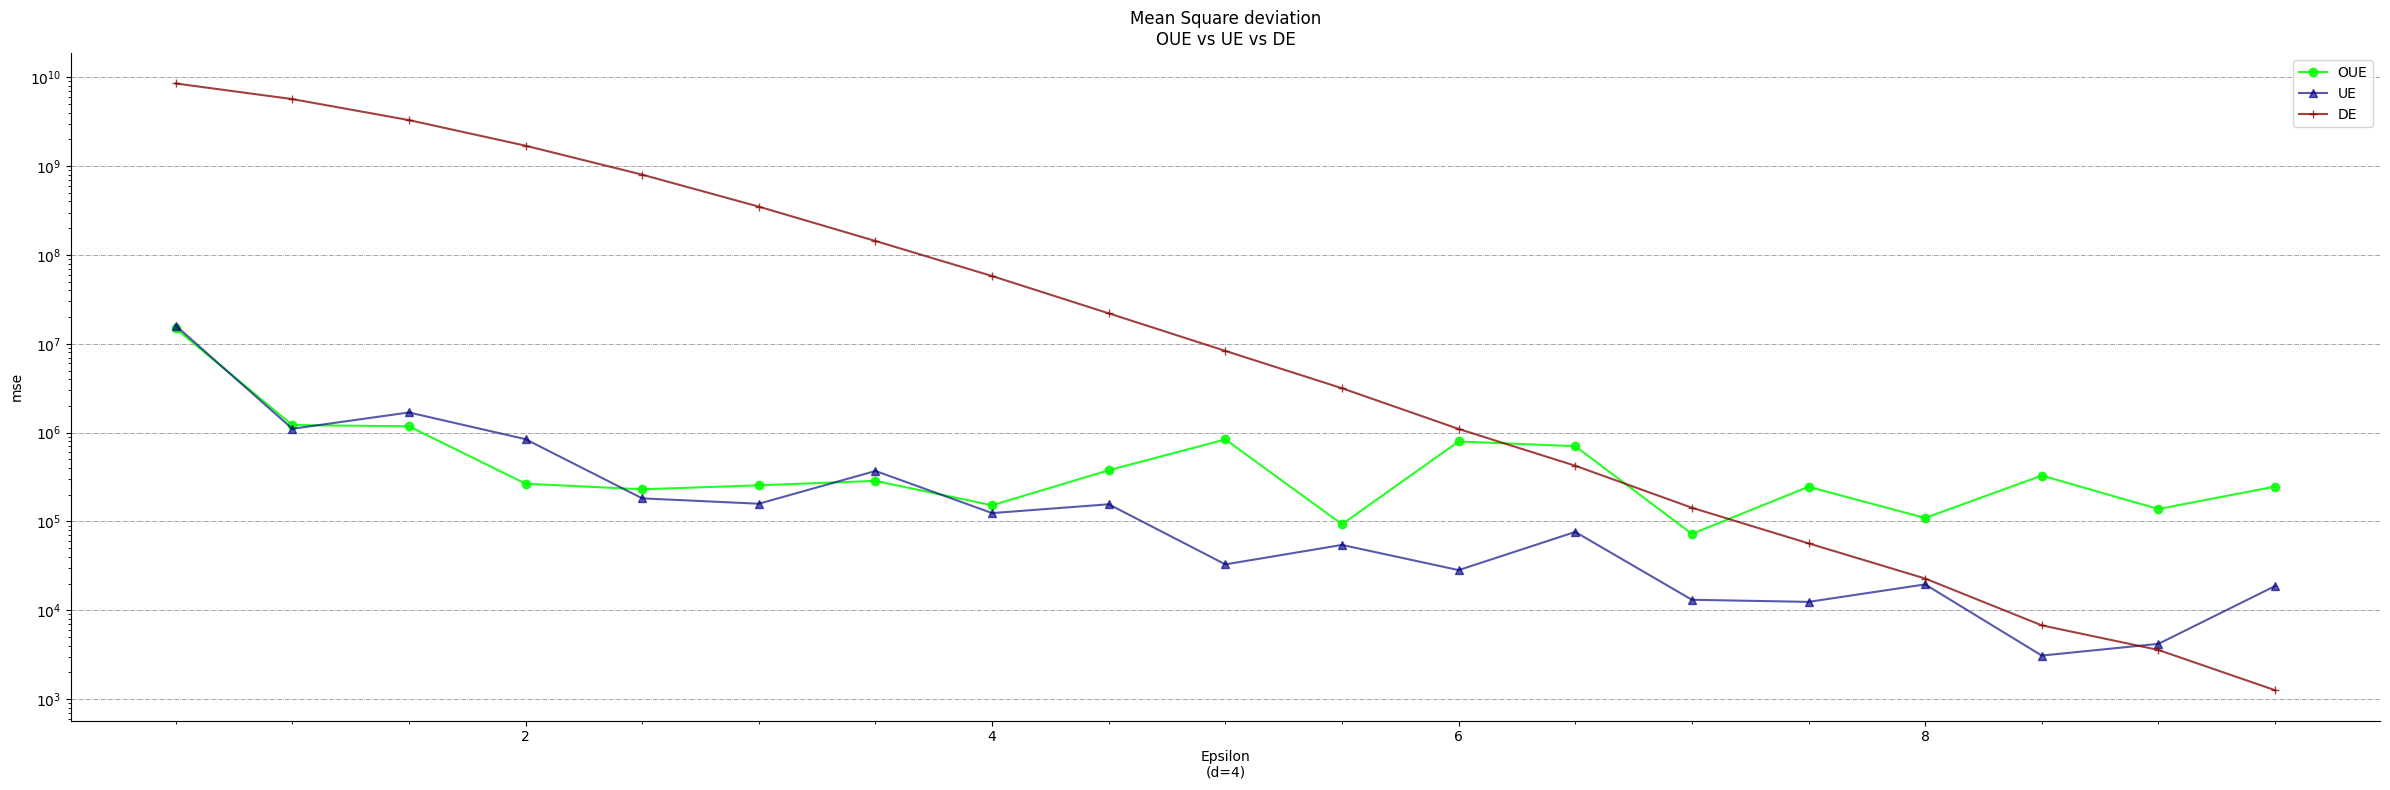

In [27]:
comparator(normal_me, eRange, **normal_args)

In [28]:
eRange = 10

zipf_args = {
    'a': 1.5,
    'n': 10**6,
    'd': 4
}

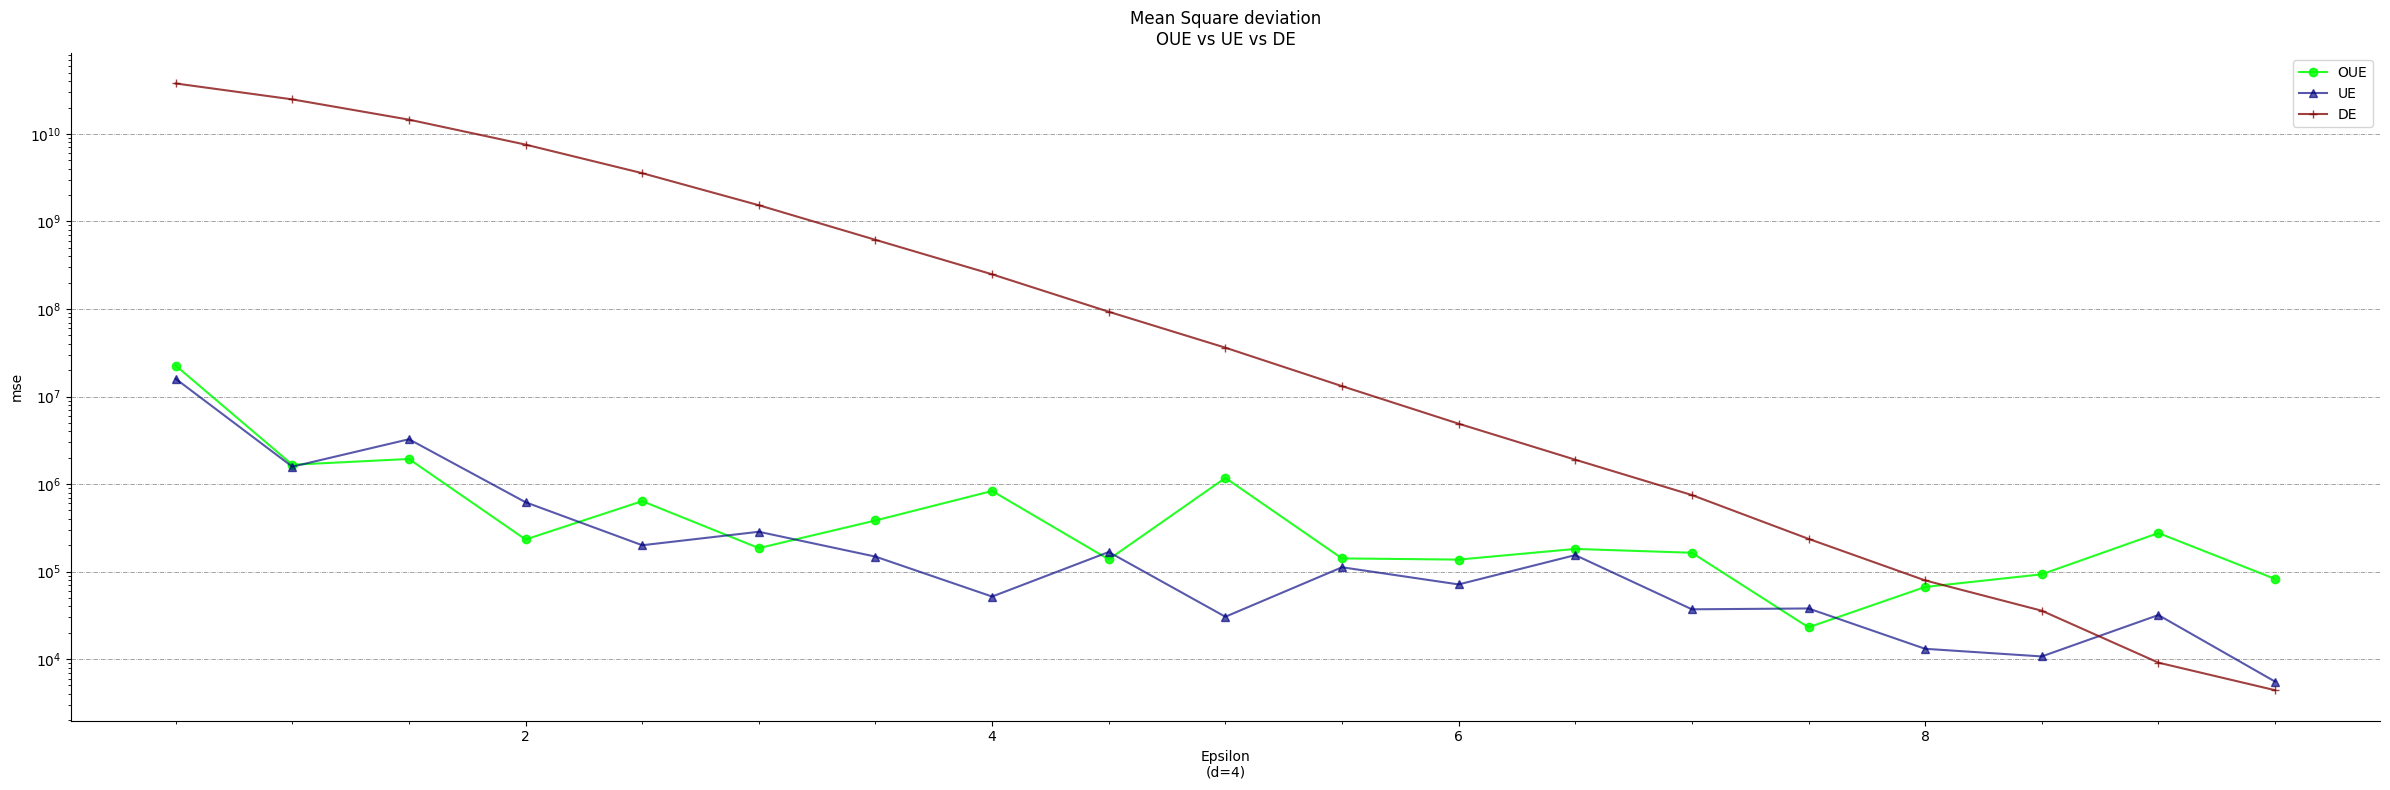

In [29]:
comparator(zipf_me, eRange, **zipf_args)

## OUE X UE X DE (d = 20)

In [30]:
eRange = 10

normal_args = {
    'd': 20,
    'mean': 10,
    'std': 2.5,
    'start': 0,
    'n': 10**6
}

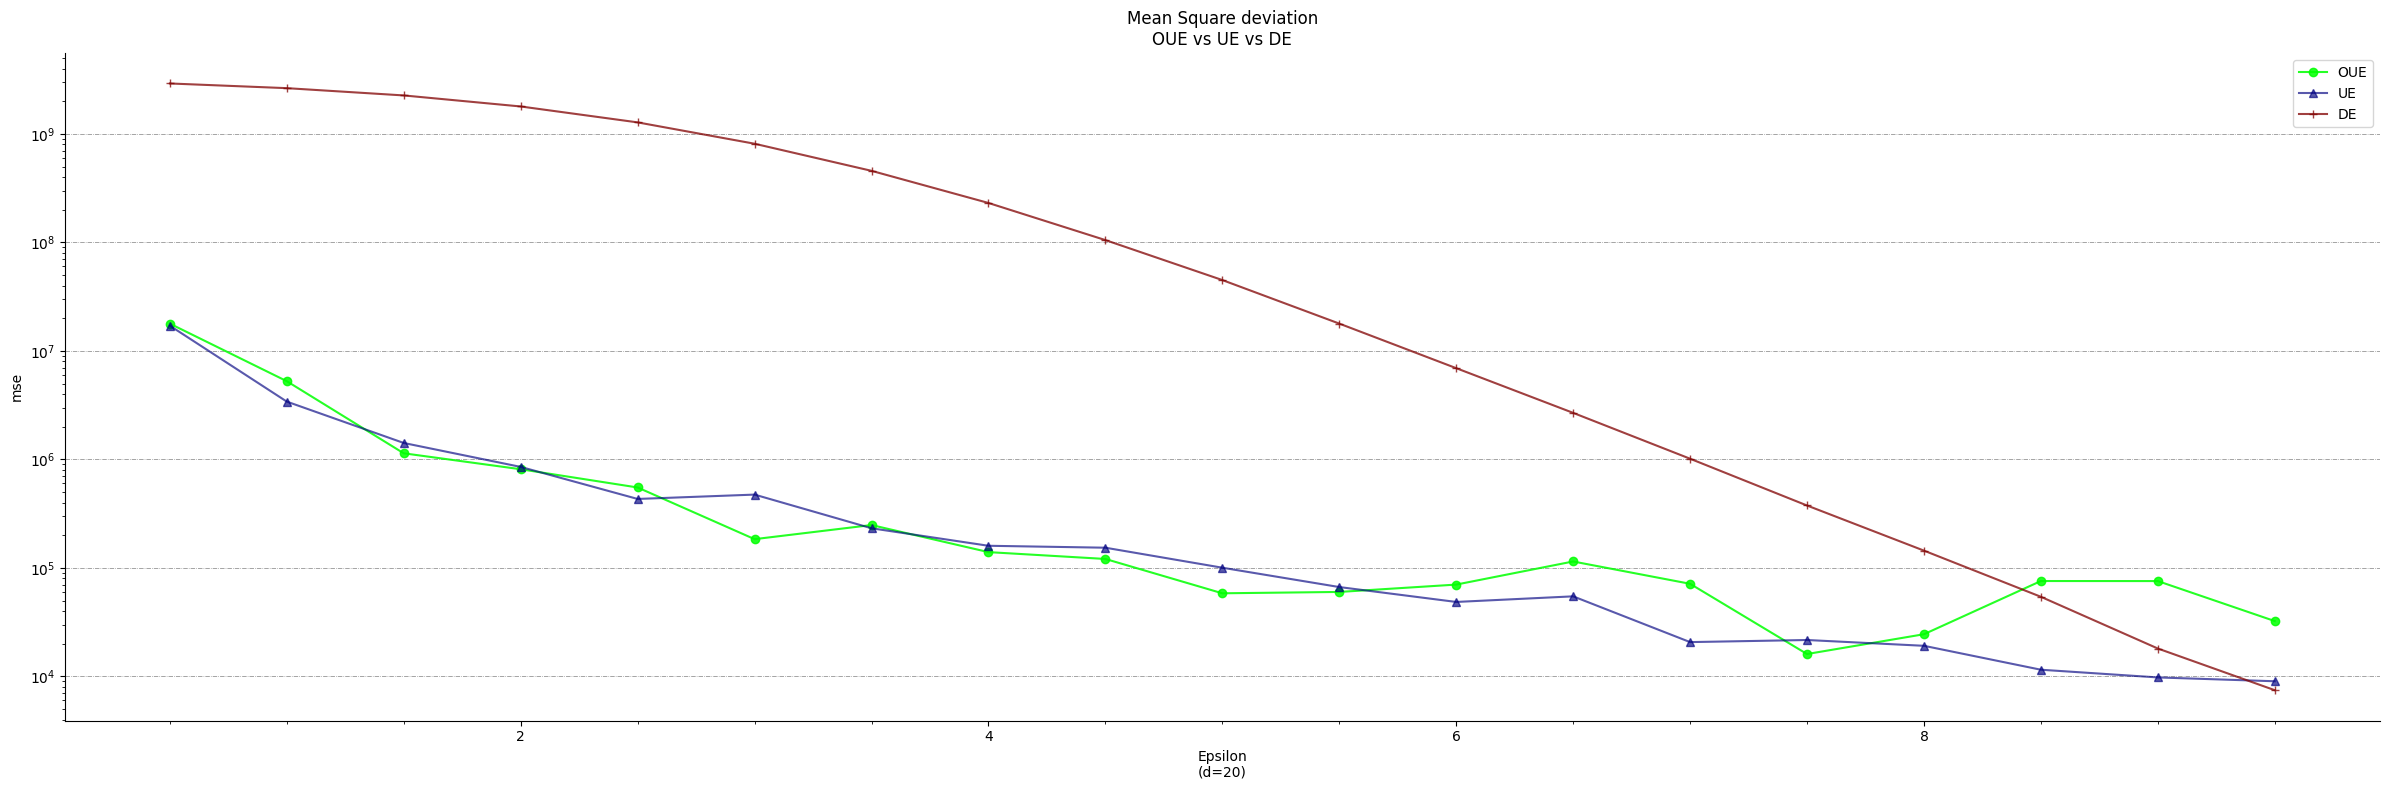

In [31]:
comparator(normal_me, eRange, **normal_args)

In [25]:
eRange = 10

zipf_args = {
    'a': 1.5,
    'n': 10**6,
    'd': 20
}

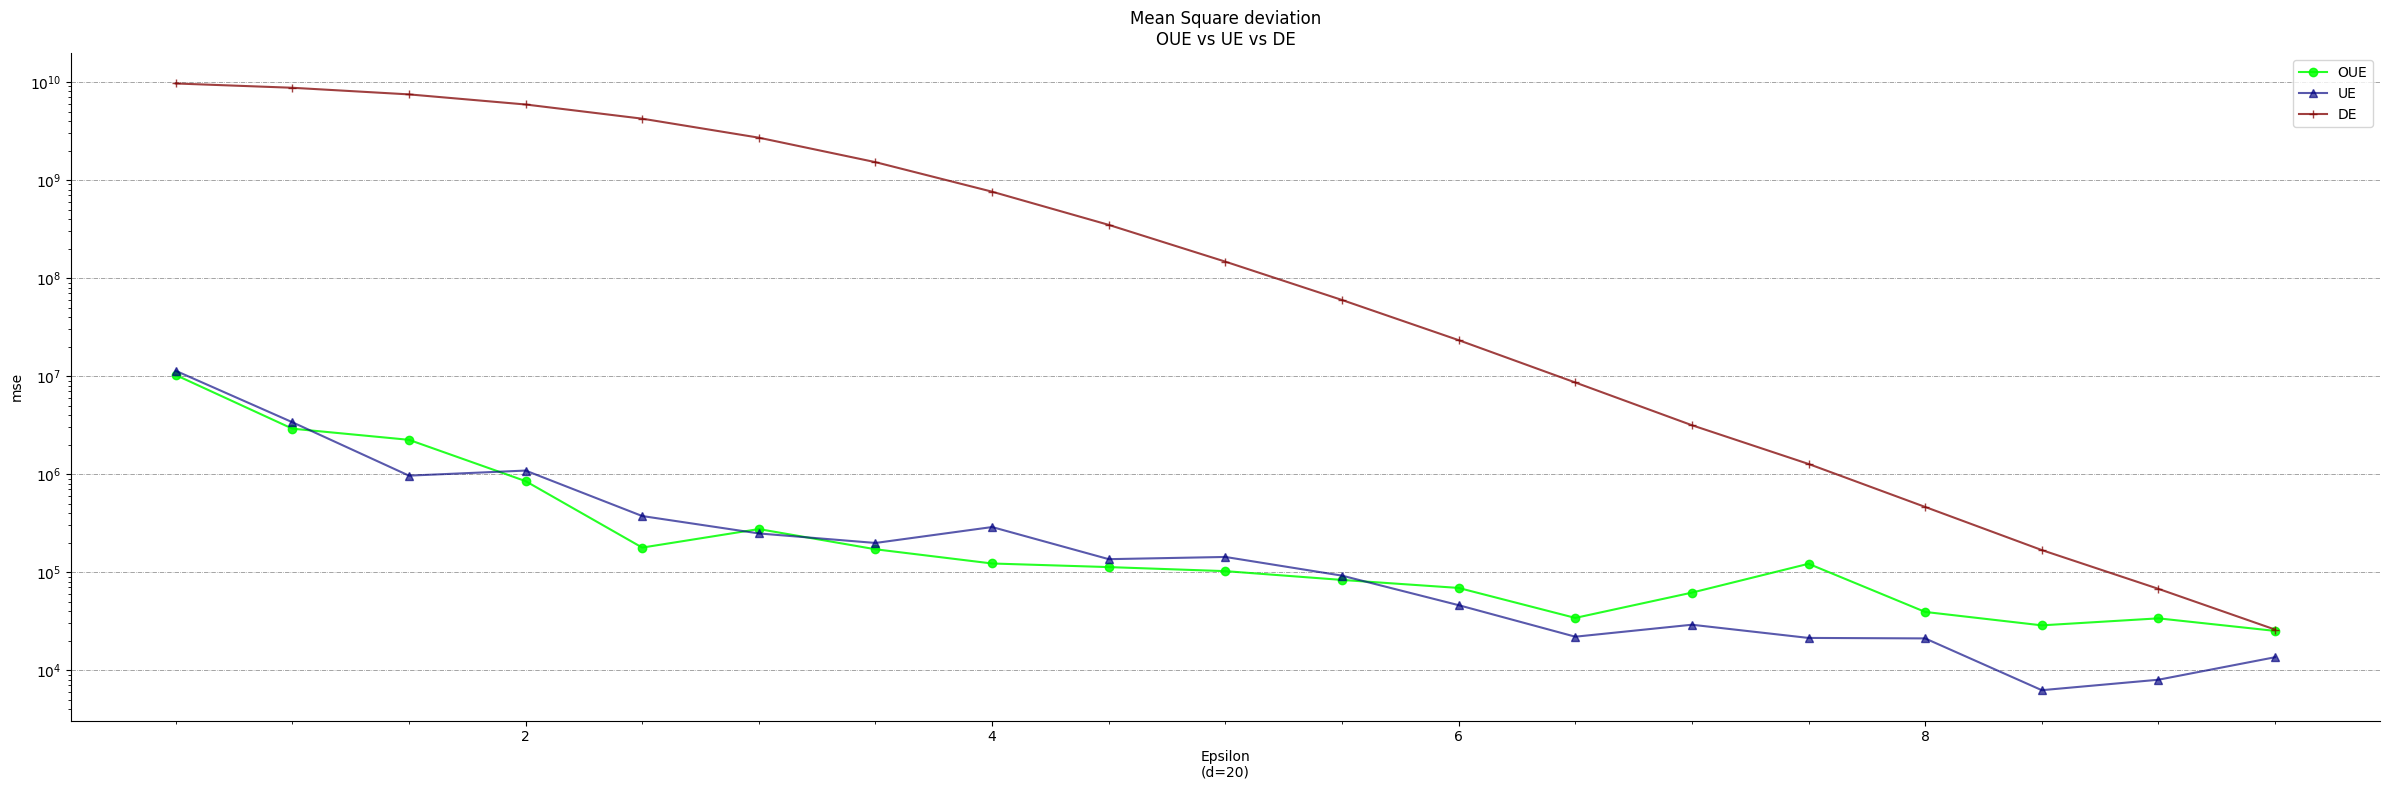

In [26]:
comparator(zipf_me, eRange, **zipf_args)

# ldp(OUE, UE, DE) VS dp(laplace mechanism)

## f

In [25]:
def comparator2(data_func, eRange, **kwargs):
    d = kwargs.get('d', 1) 
    domain = [i for i in range(0, d)]

    responses = data_func(**kwargs)
    countsTruth = np.sum([encode(r, domain) for r in responses], axis = 0)
    
    mse_valuesDE = []
    mse_valuesUE = []
    mse_valuesOUE = []
    mse_valuesLA = []

    epsilon_values = []

    for i in range(1, eRange*2):
        epsilon = i/2
    
        pOUE, qOUE = optimized_p_q(epsilon)
        pUE, qUE = symetric_p_q(epsilon)
        pDE, qDE = DE_p_q(epsilon, len(domain))
    
        ##--------------------------------------------------------------
        responsesOUE = [perturb(encode(r, domain), pOUE, qOUE) for r in responses]
        countsOUE = aggregate(responsesOUE, pOUE, qOUE)
        #optmize
        #use a fix d vector and a new d aggregated vector in which the noisy aggregation will be deposited
        #don't save all the responses, memory cuts out
        
        responsesUE = [perturb(encode(r, domain), pUE, qUE) for r in responses]
        countsUE = aggregate(responsesUE, pUE, qUE)
    
        responsesDE = [randomized_response_DE(epsilon, domain, r) for r in responses]
        countsDE = np.sum([encode(r, domain) for r in responsesDE], axis = 0)
        countsDEagg = aggregateDE(countsDE, pDE, qDE, len(responses))

        countsLA = laplace_mech(countsTruth, 1, epsilon)
        #div by d
        
        ##--------------------------------------------------------------
    
        mseOUE = metrics(countsTruth, countsOUE)
        mseDE = metrics(countsTruth, countsDE)
        mseUE = metrics(countsTruth, countsUE)
        mseLA = metrics(countsTruth, countsLA)
    
        mse_valuesOUE.append(mseOUE)
        mse_valuesUE.append(mseUE)
        mse_valuesDE.append(mseDE)
        mse_valuesLA.append(mseLA)
        
        epsilon_values.append(epsilon)

    plt.figure(figsize=(24, 8))

    plt.plot(epsilon_values, mse_valuesOUE, marker='o', color='lime', alpha=0.85, label='OUE')
    plt.plot(epsilon_values, mse_valuesUE, marker='^', color='navy', alpha=0.65, label='UE')
    plt.plot(epsilon_values, mse_valuesDE, marker='+', color='maroon', alpha=0.75, label='DE')
    plt.plot(epsilon_values, mse_valuesLA, marker='x', color='orange', alpha=0.9, label='LA')
    
    plt.title('Mean Square deviation\nOUE vs UE vs DE vs Laplace Meachanism')
    plt.xlabel(f'Epsilon\n(d={len(domain)})')
    plt.ylabel('mse')
    plt.yscale('log')
    plt.legend()
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    plt.minorticks_on()

    plt.grid(axis='y', linestyle='-.', linewidth=0.5, alpha=0.5, color='black')
    
    plt.tight_layout()
    plt.show()

## stuff

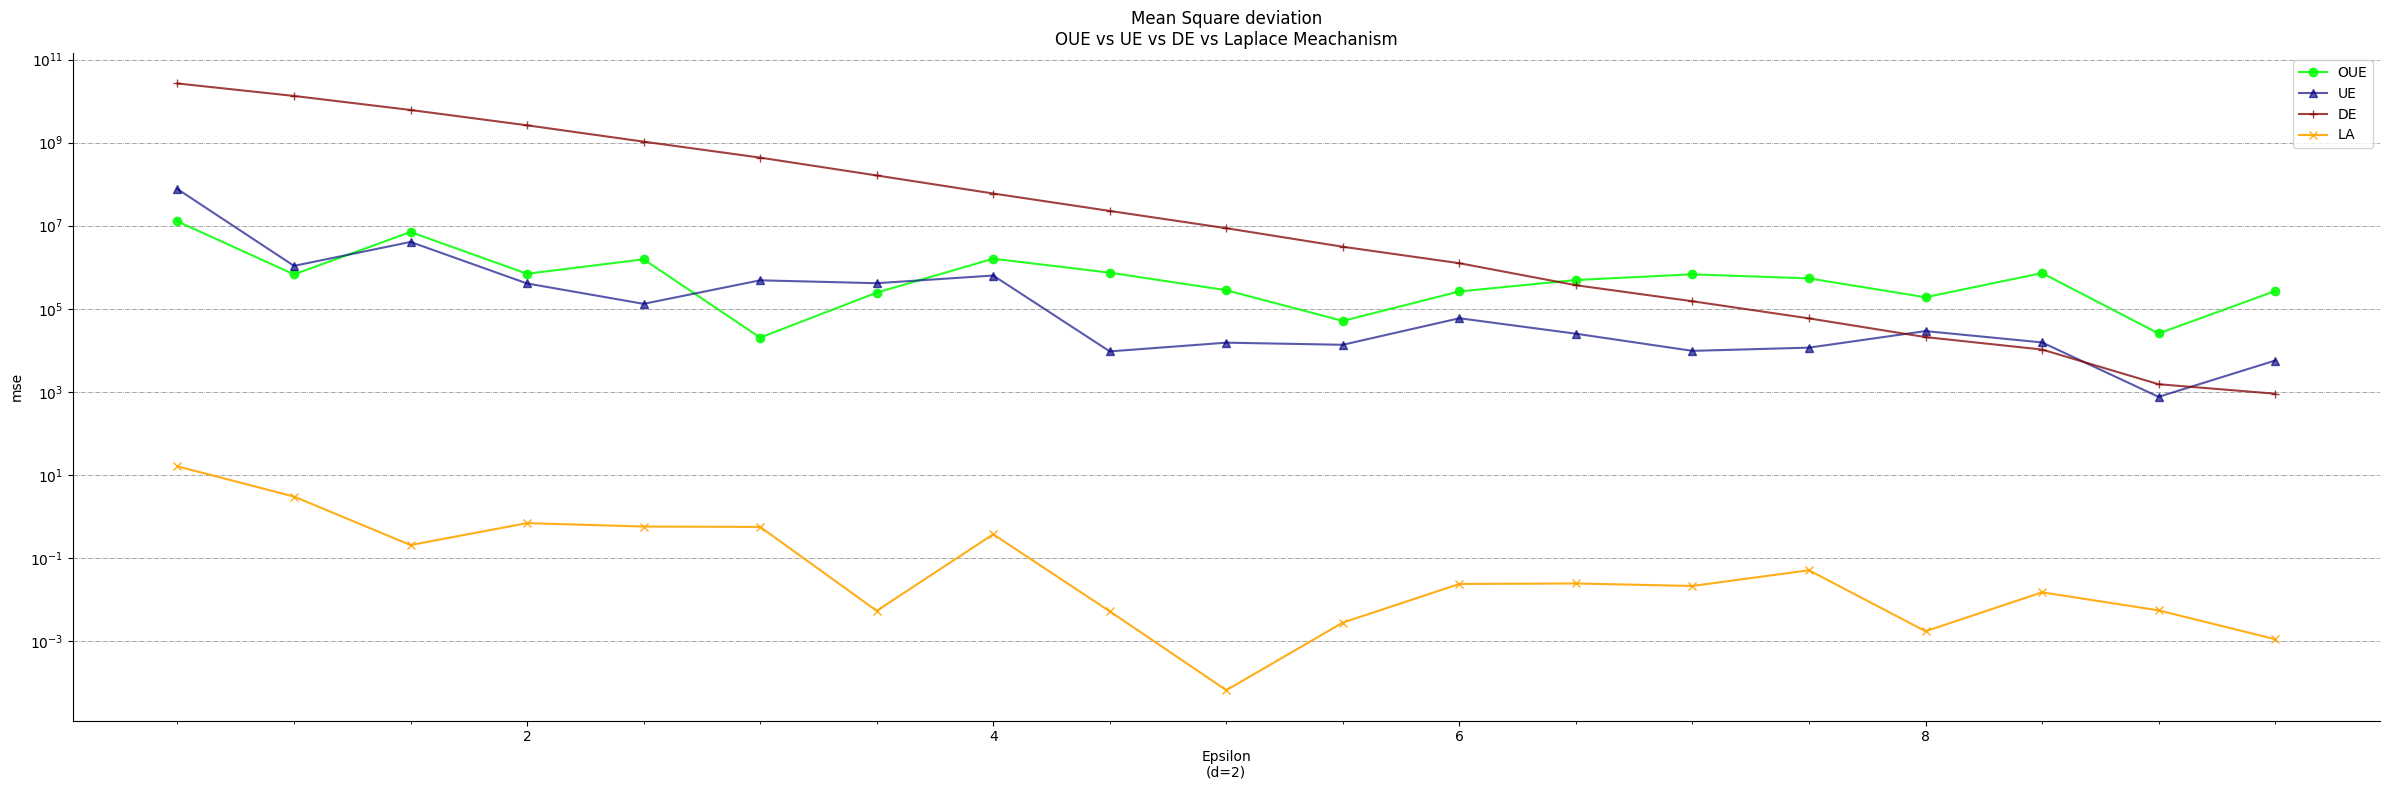

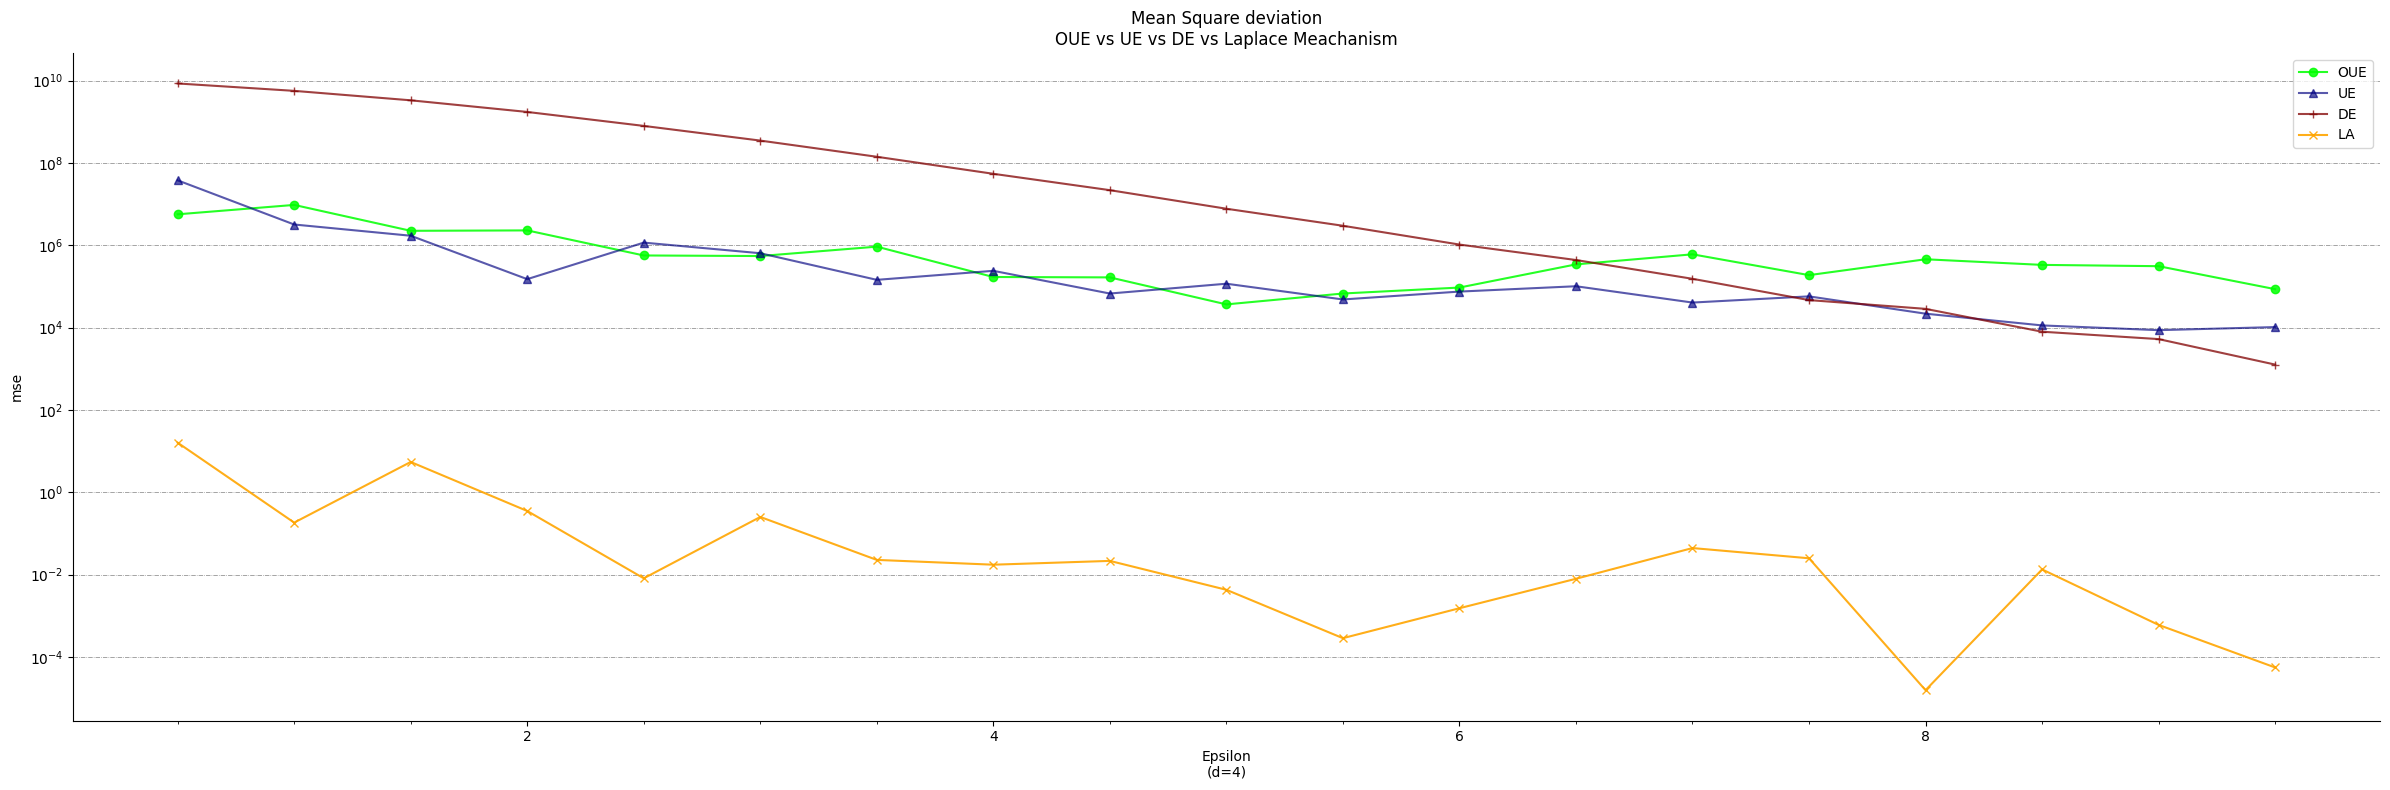

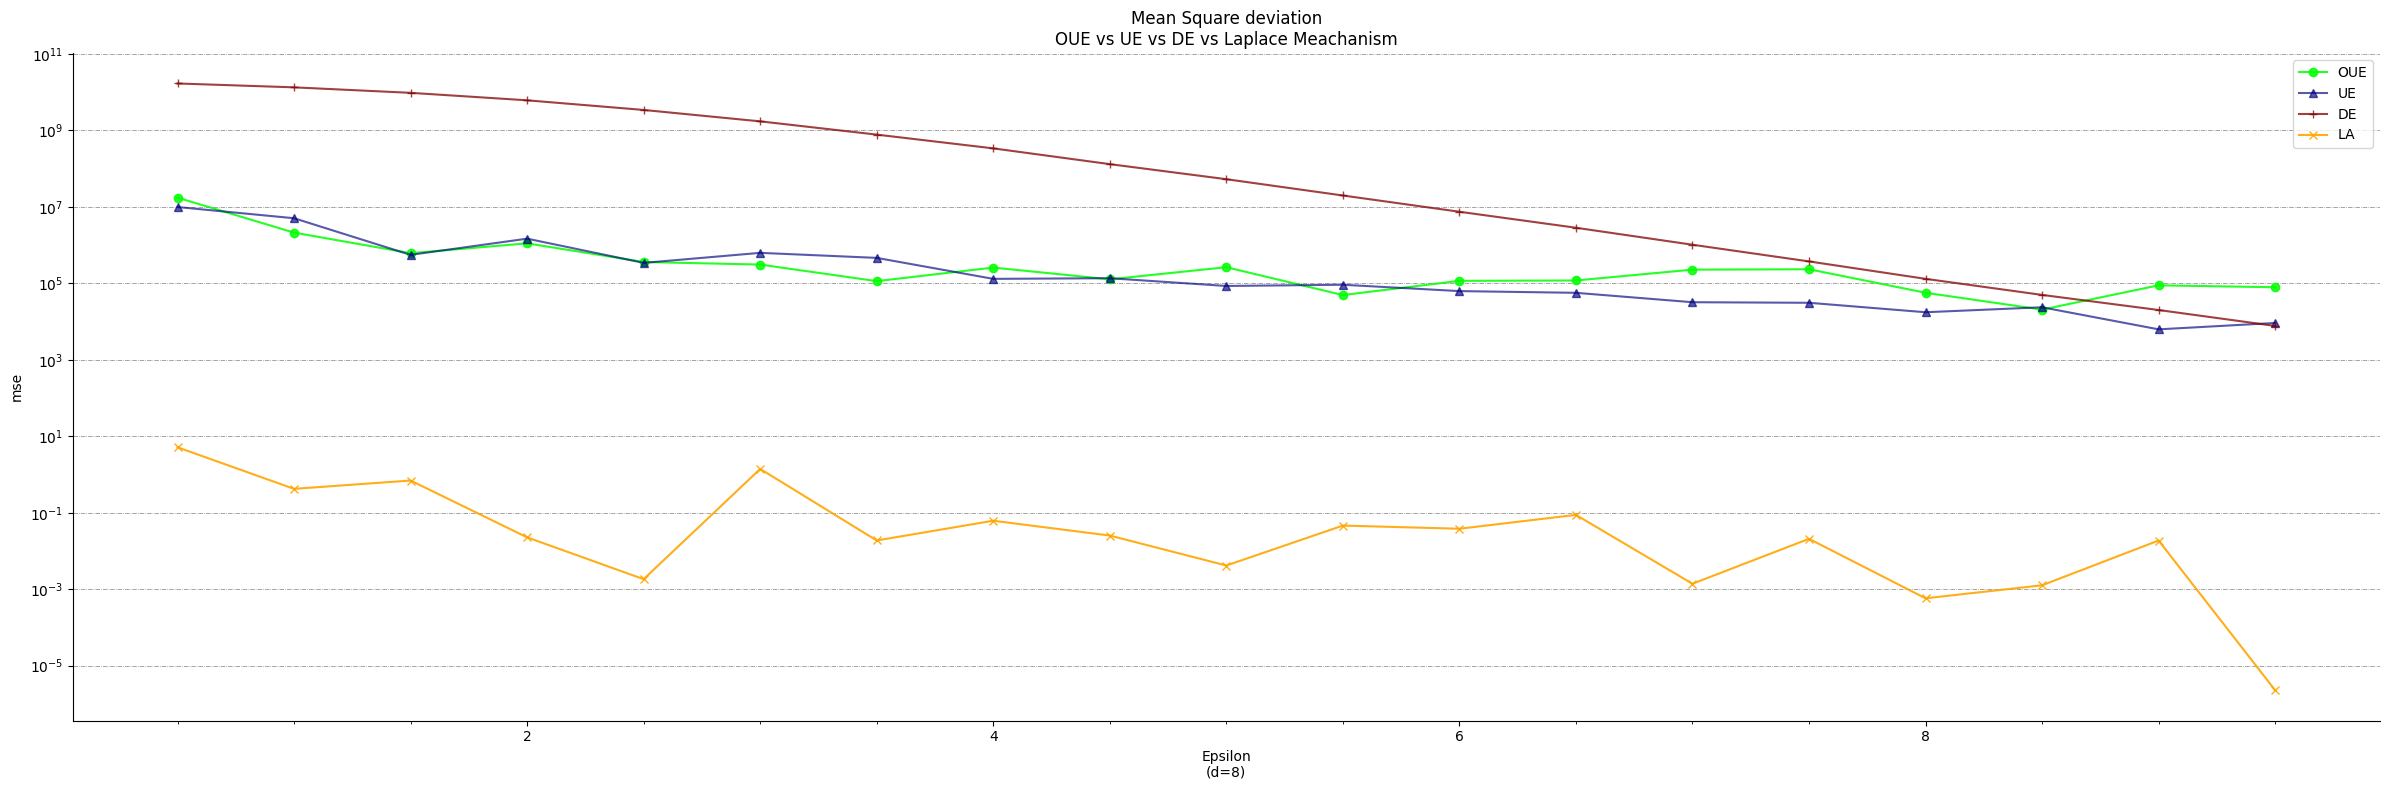

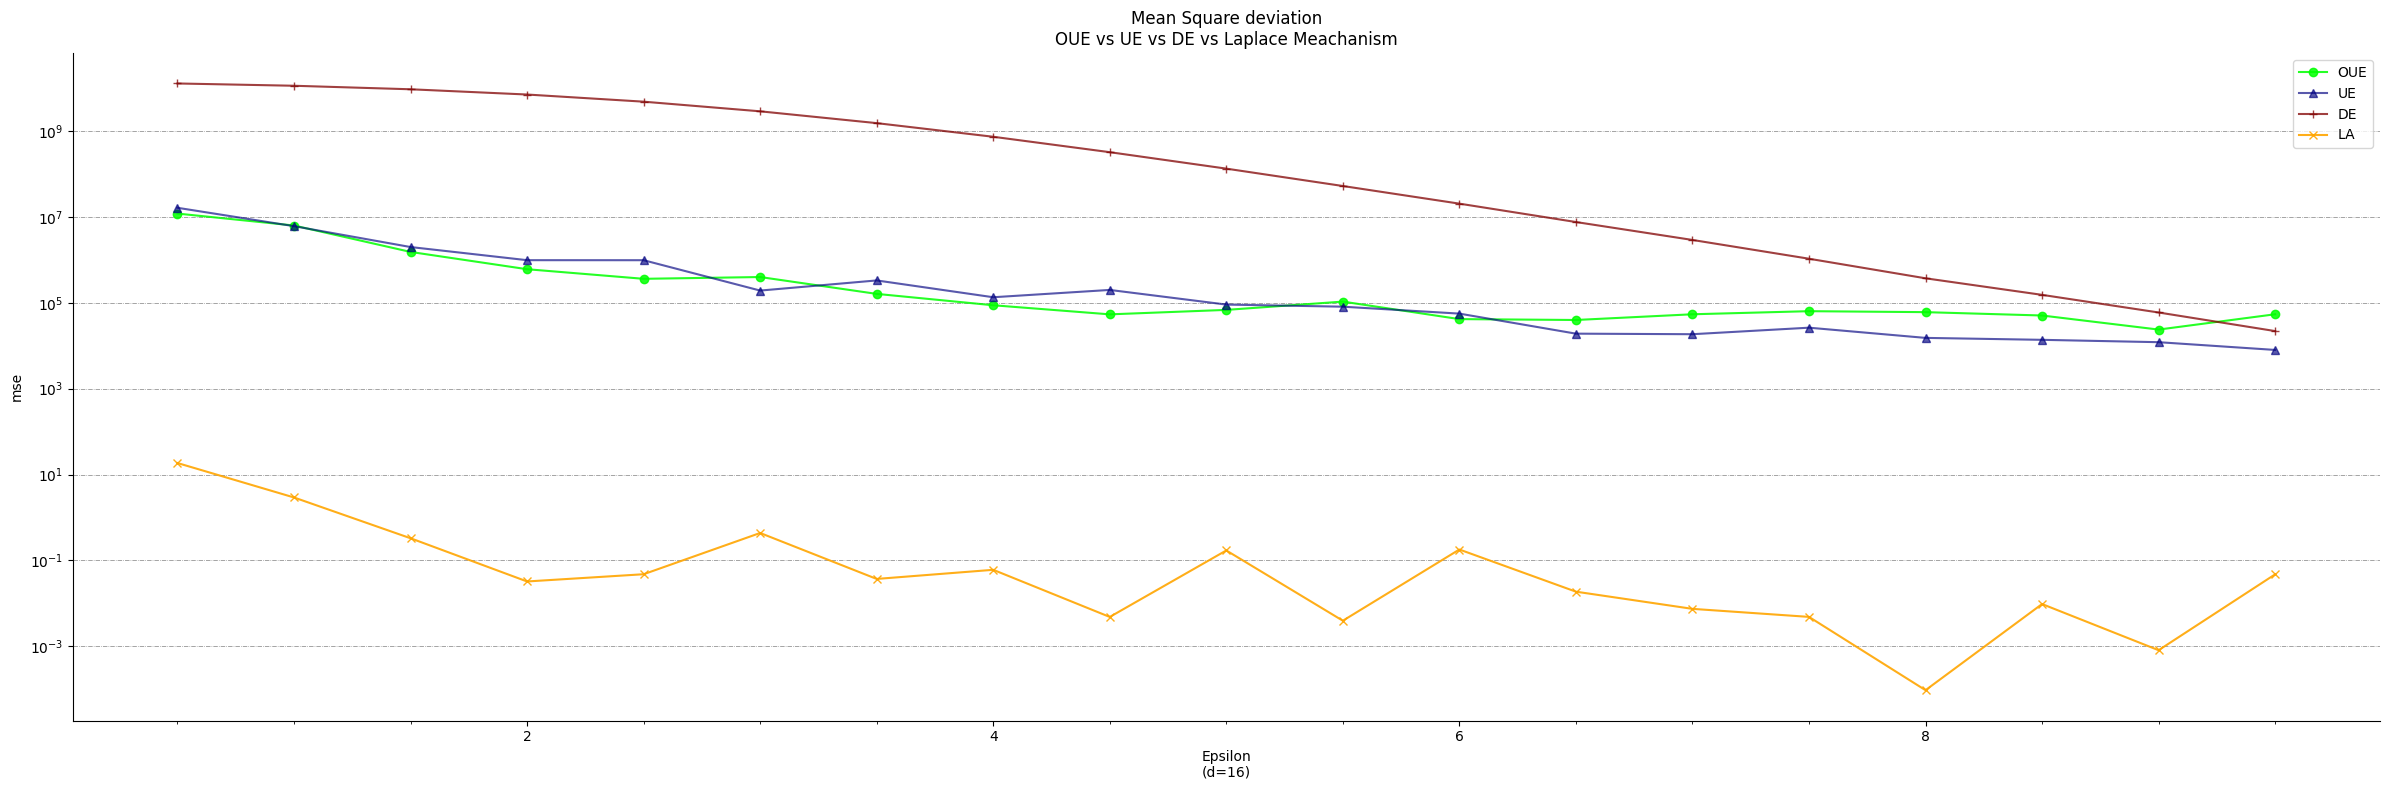

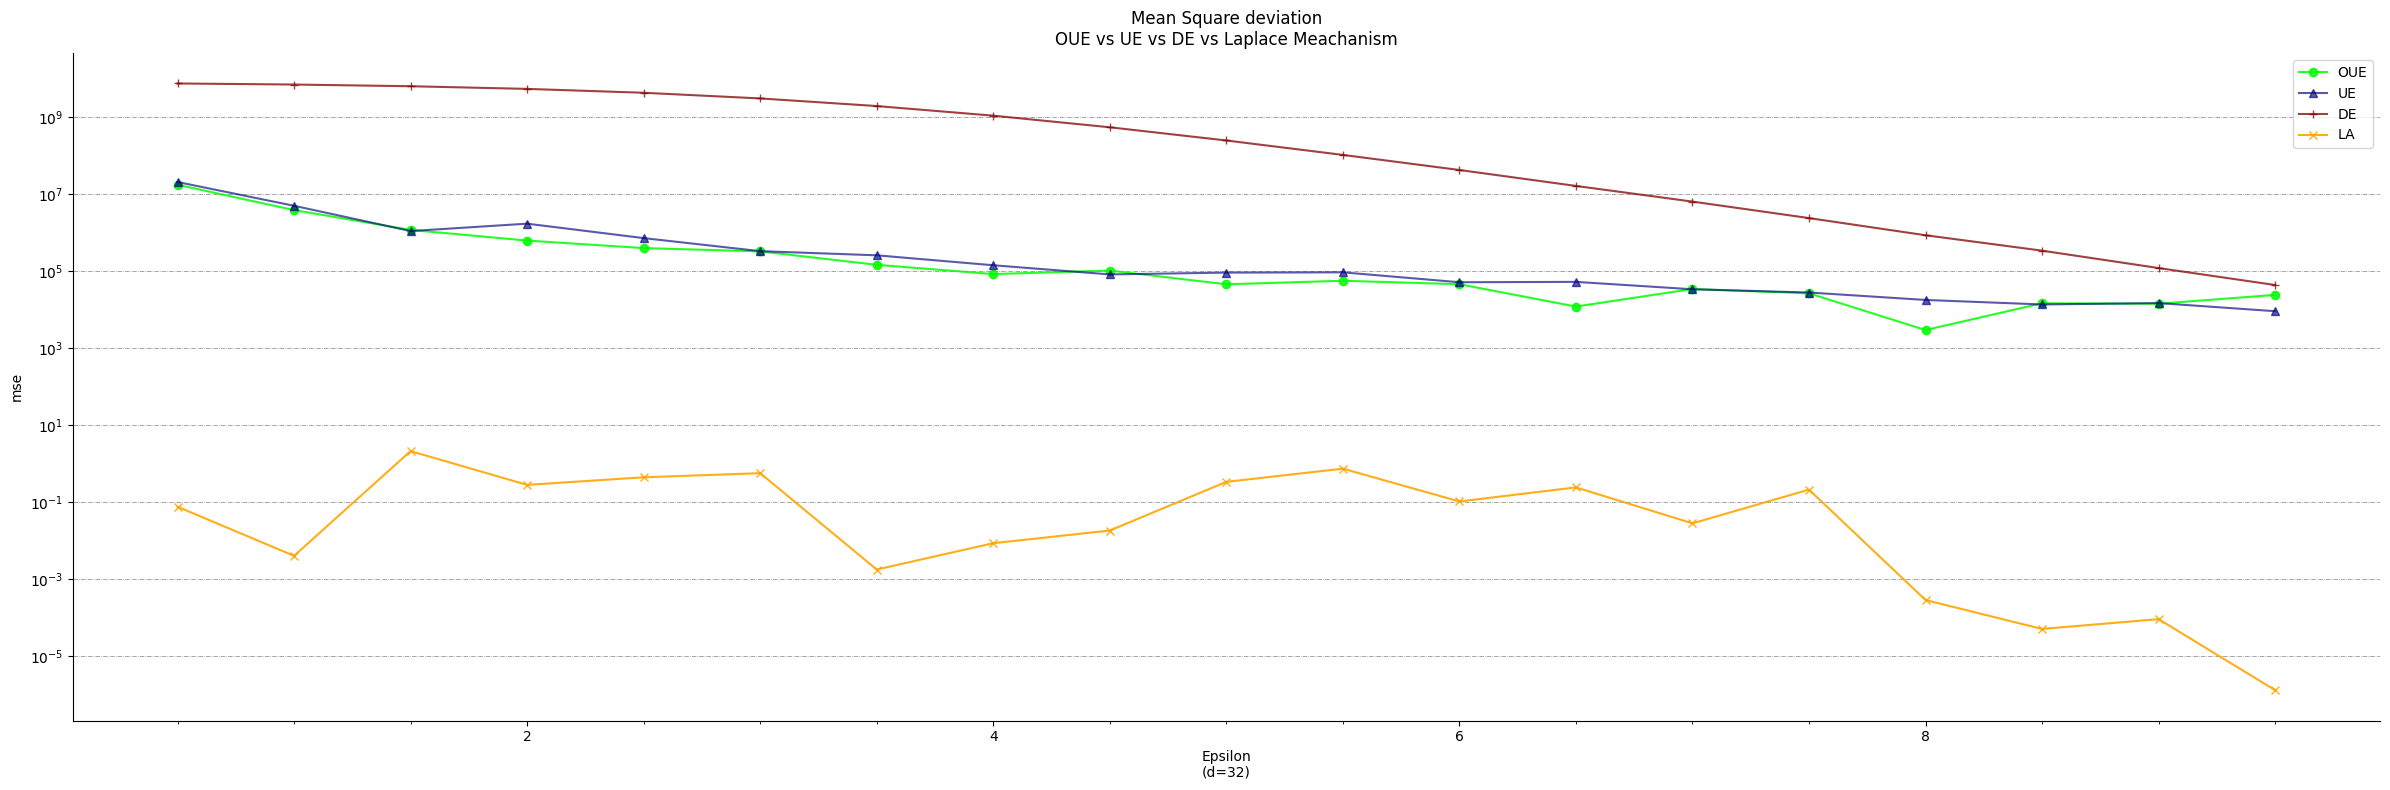

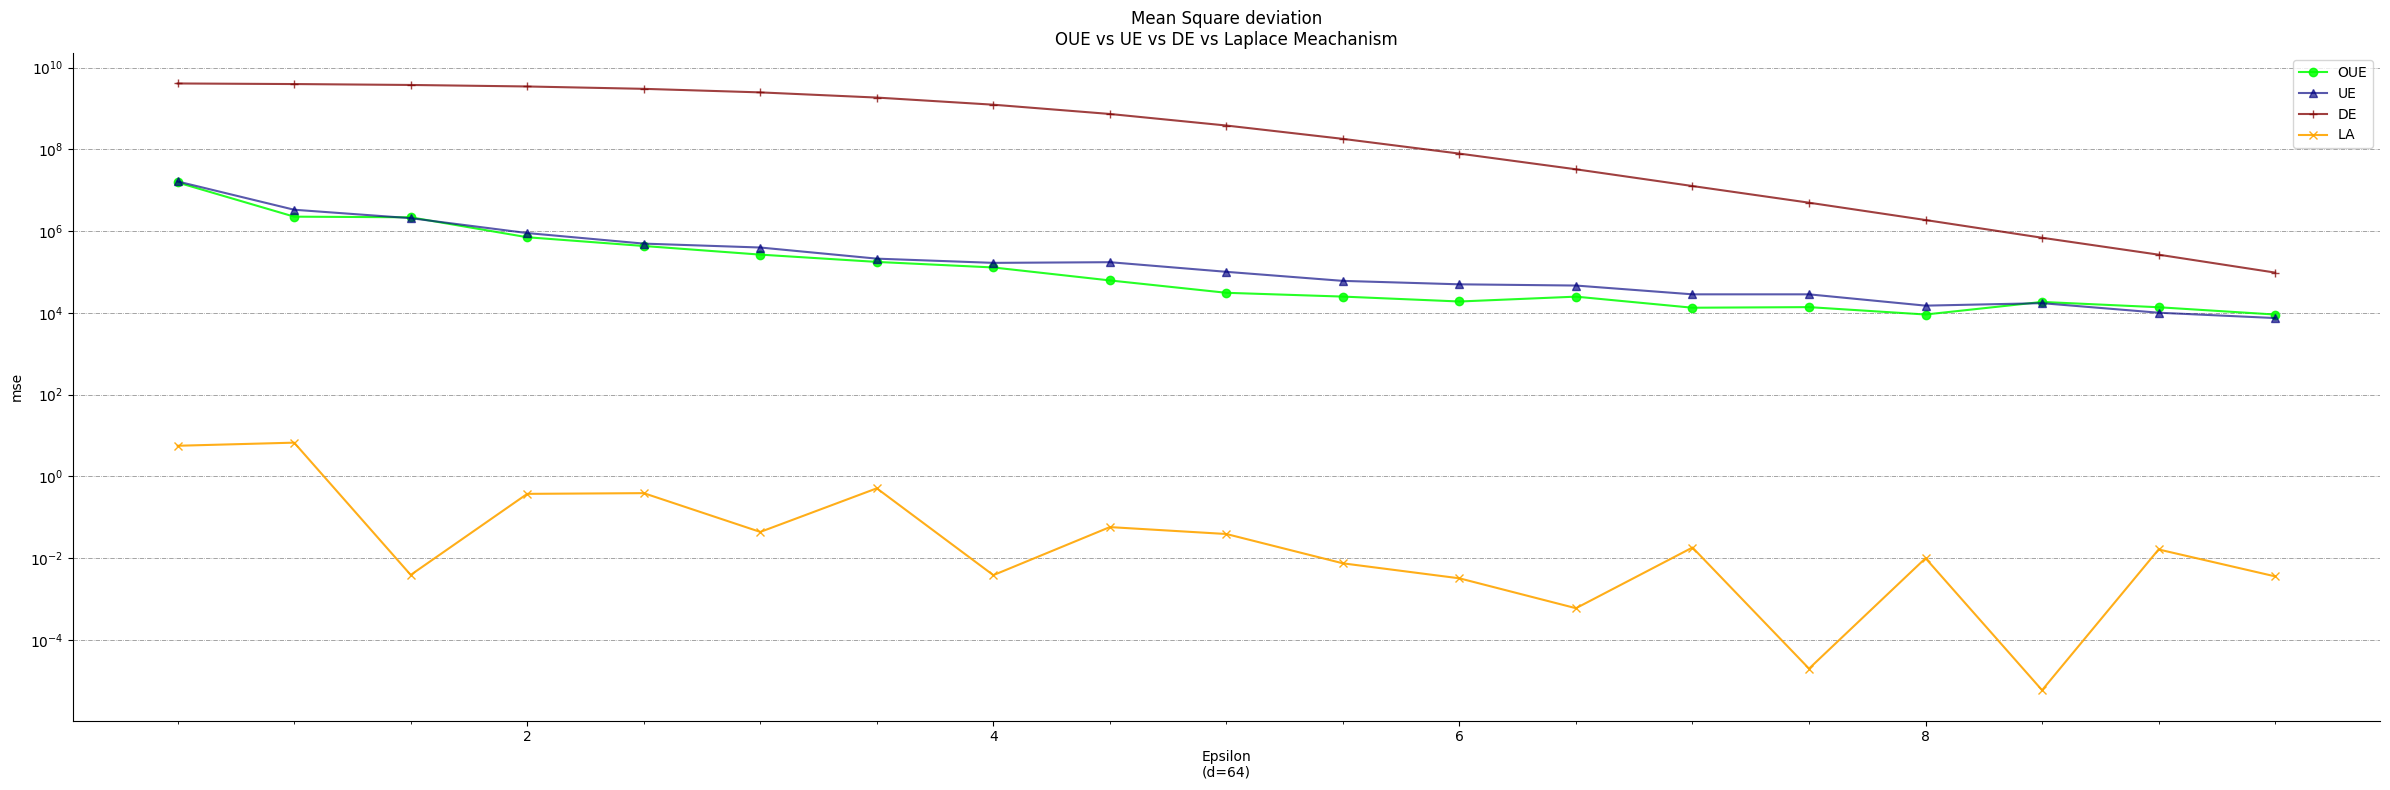

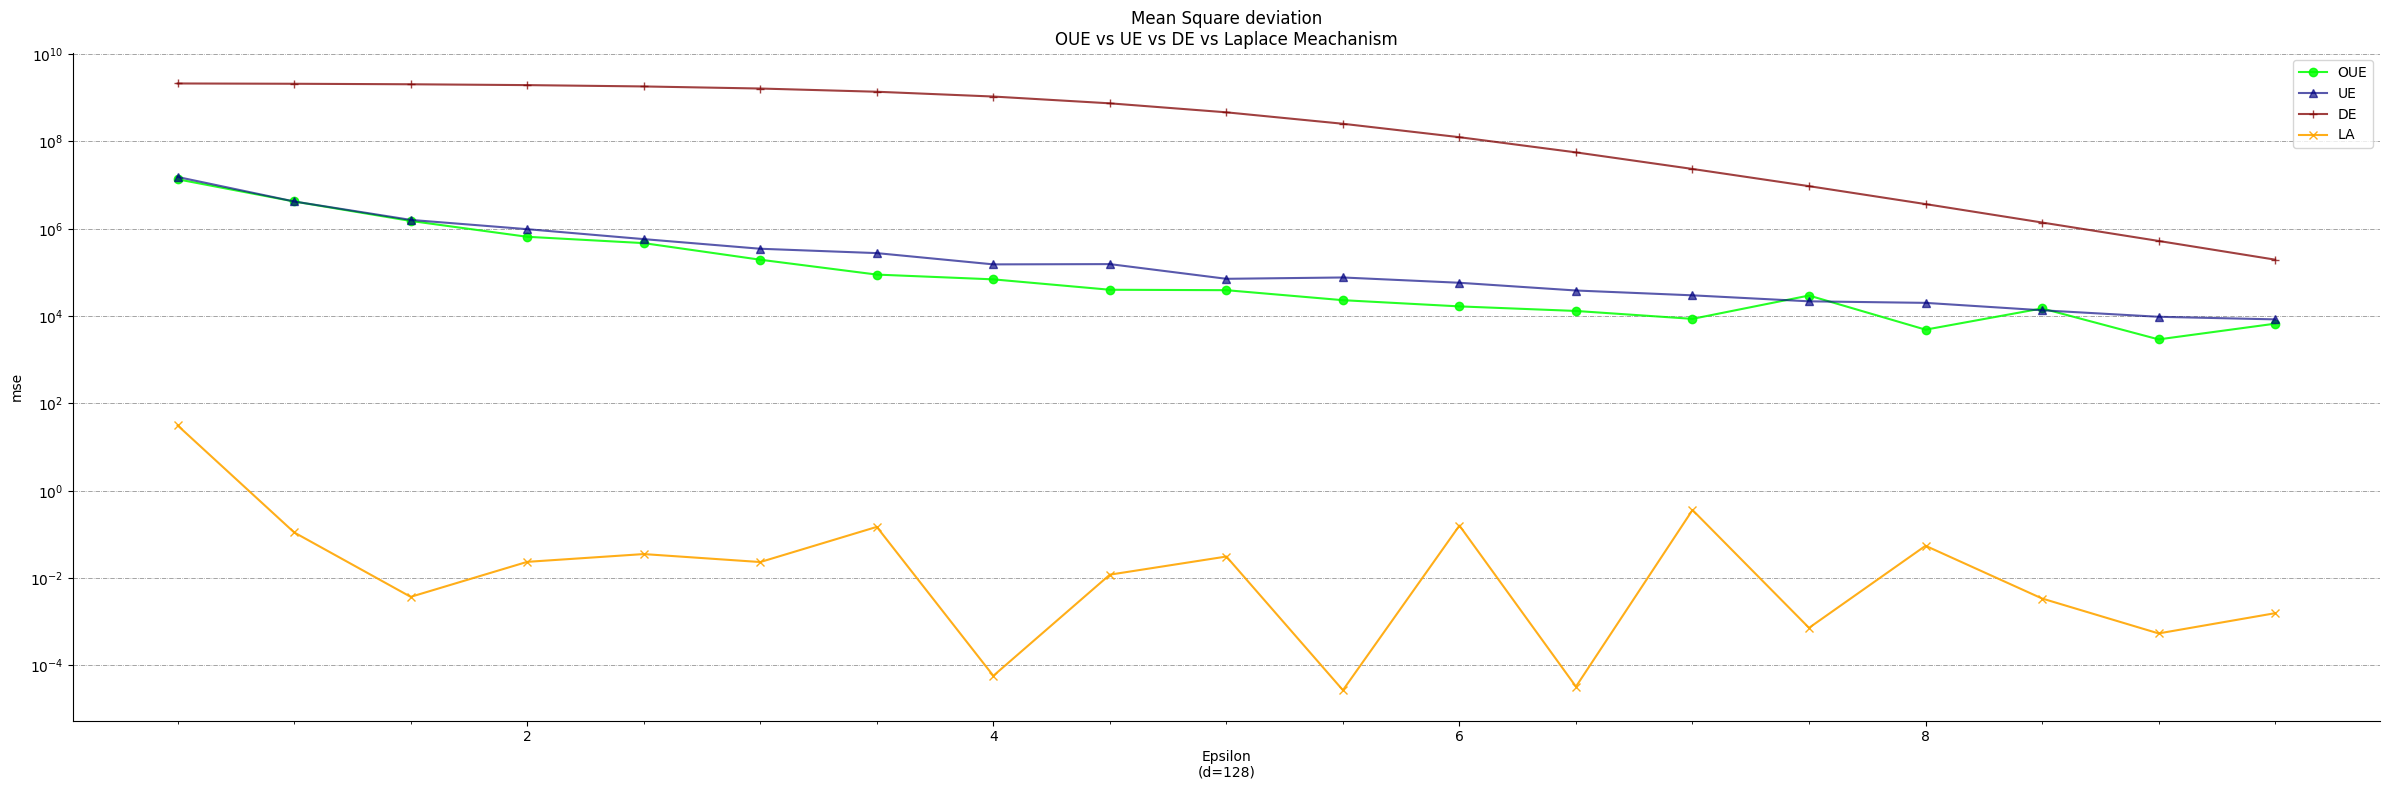

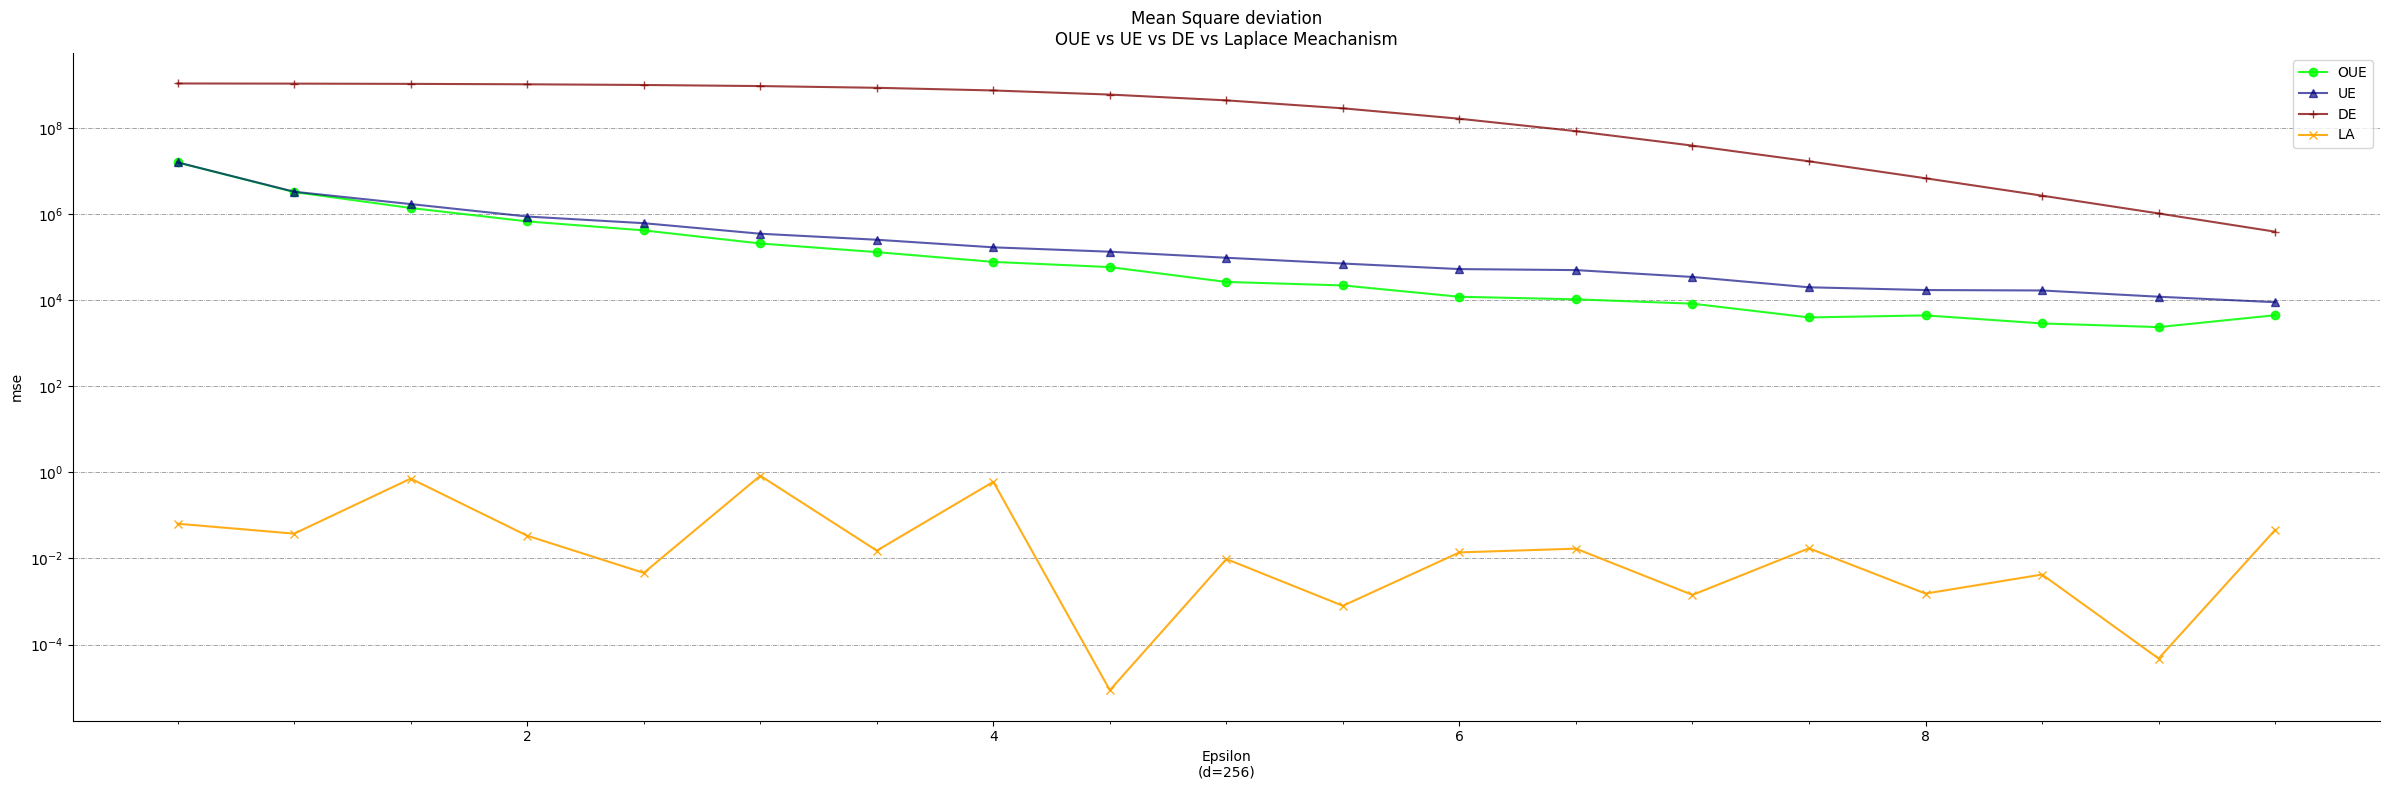

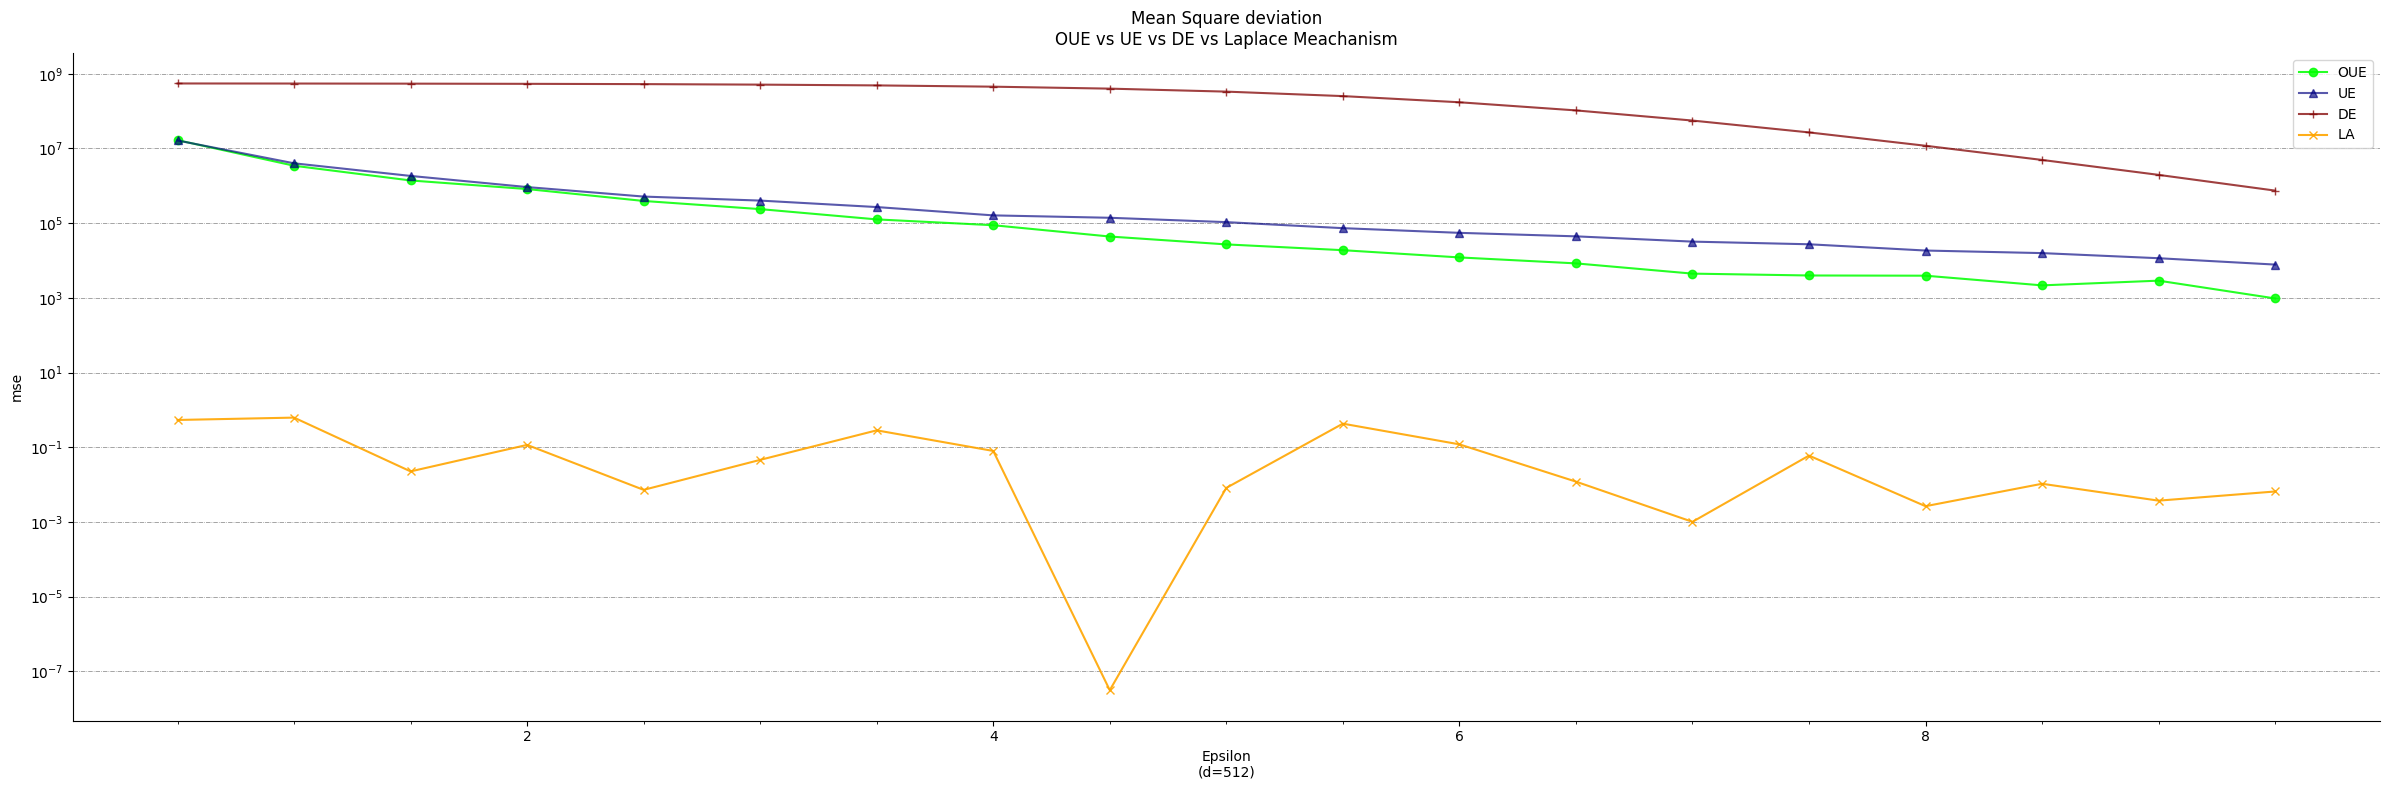

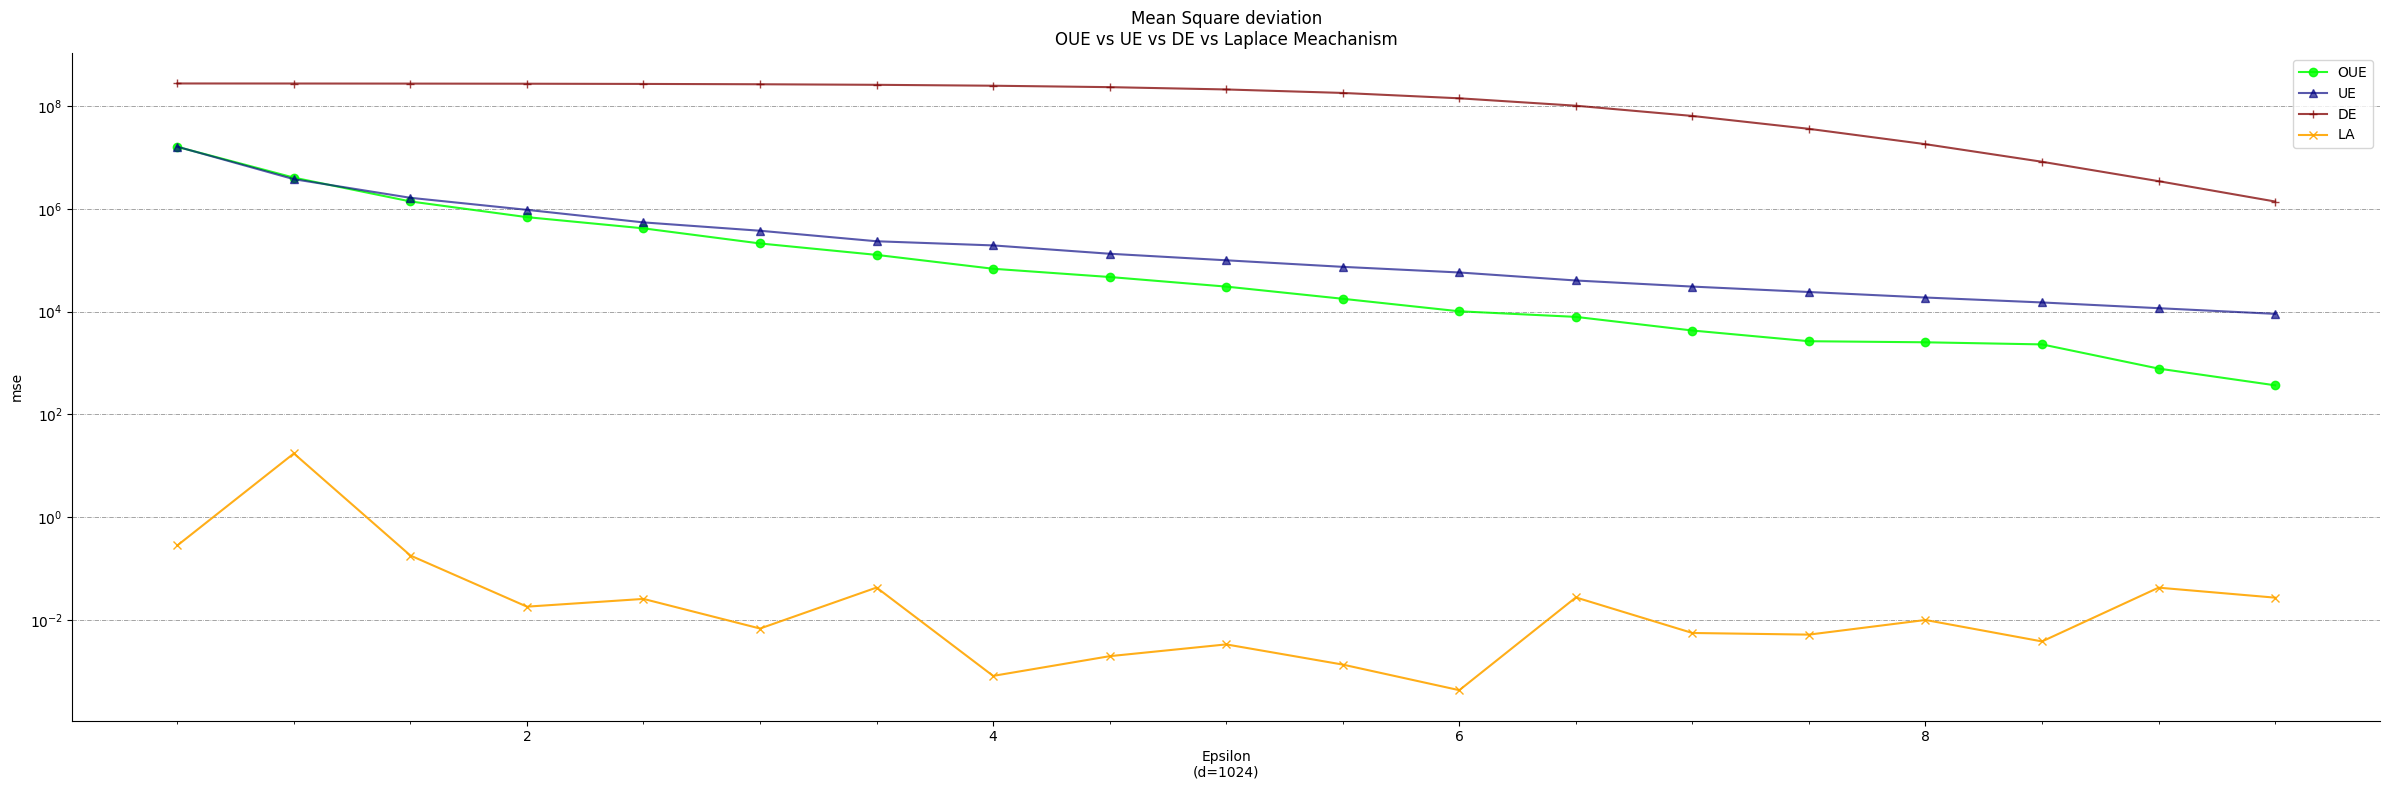

MemoryError: Unable to allocate 15.3 GiB for an array with shape (1000000, 2048) and data type int64

In [28]:
for i in range(1,12):
    d = 2**i

    eRange = 10

    normal_args = {
        'd': d,
        'mean': 2,
        'std': 1,
        'start': 0,
        'n': 10**6
    }

    comparator2(normal_me, eRange, **normal_args)

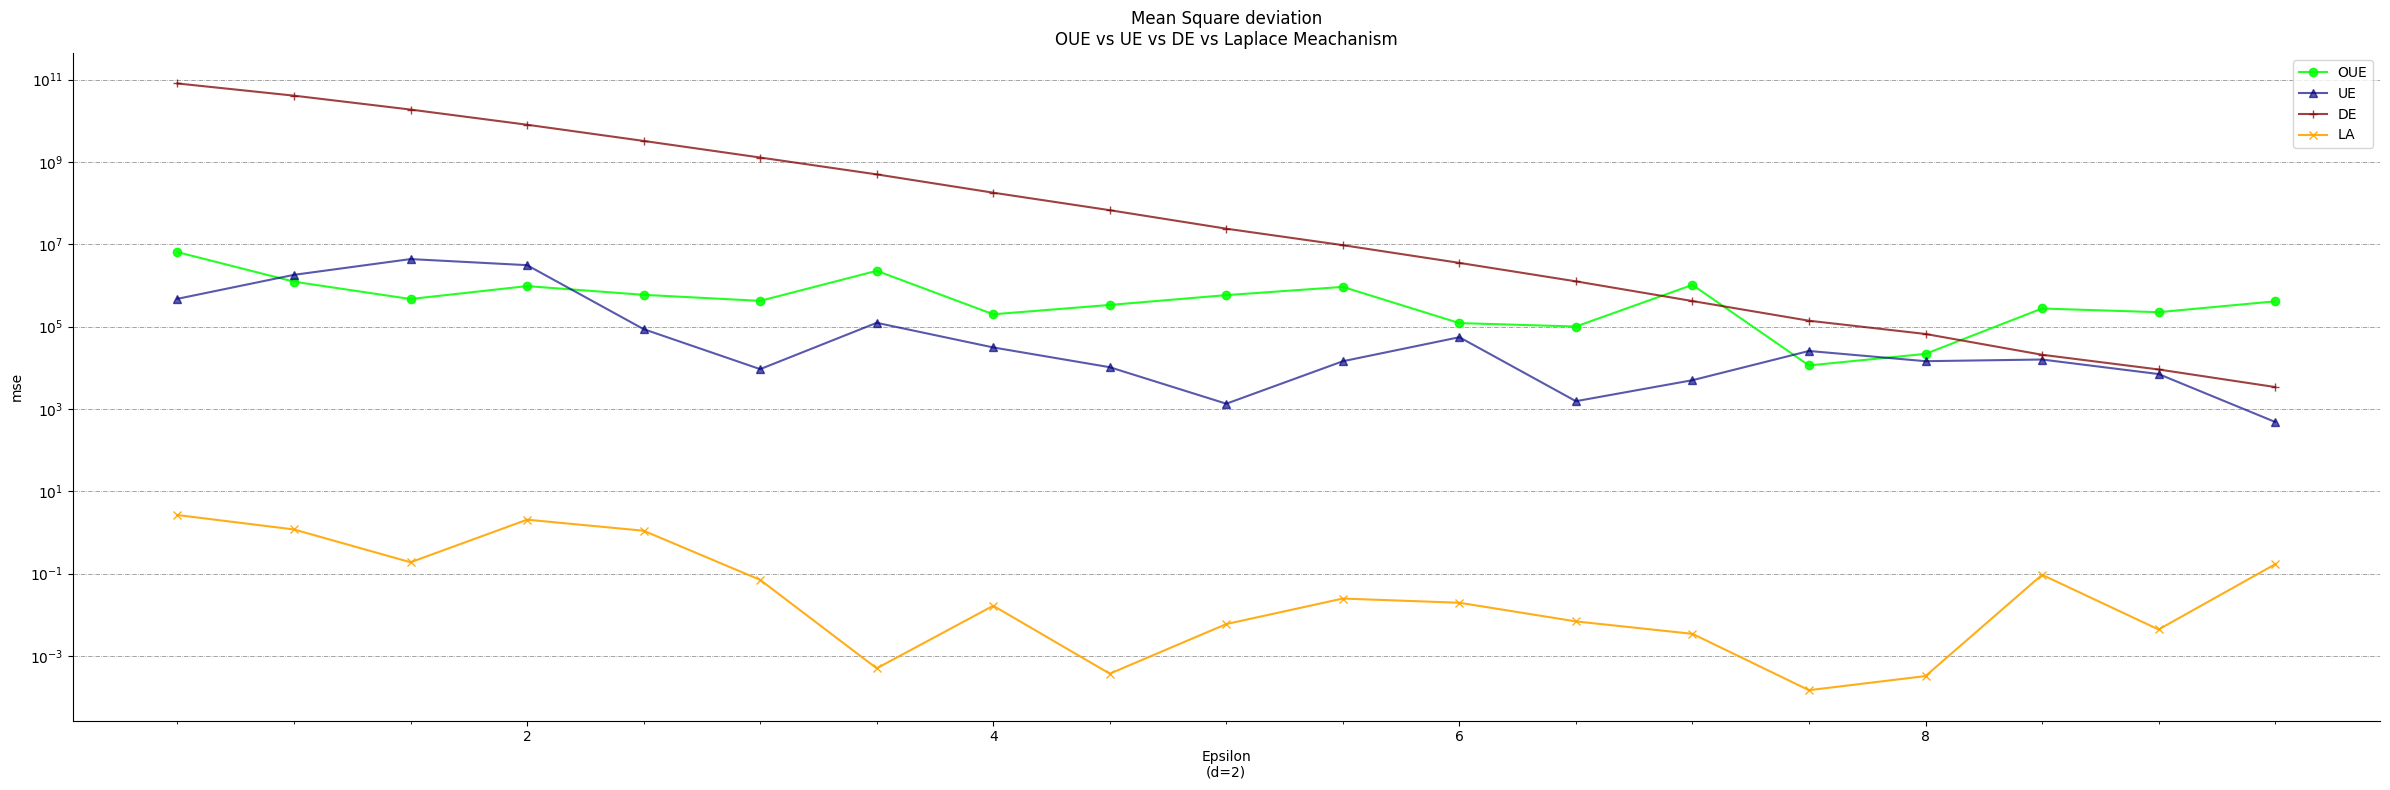

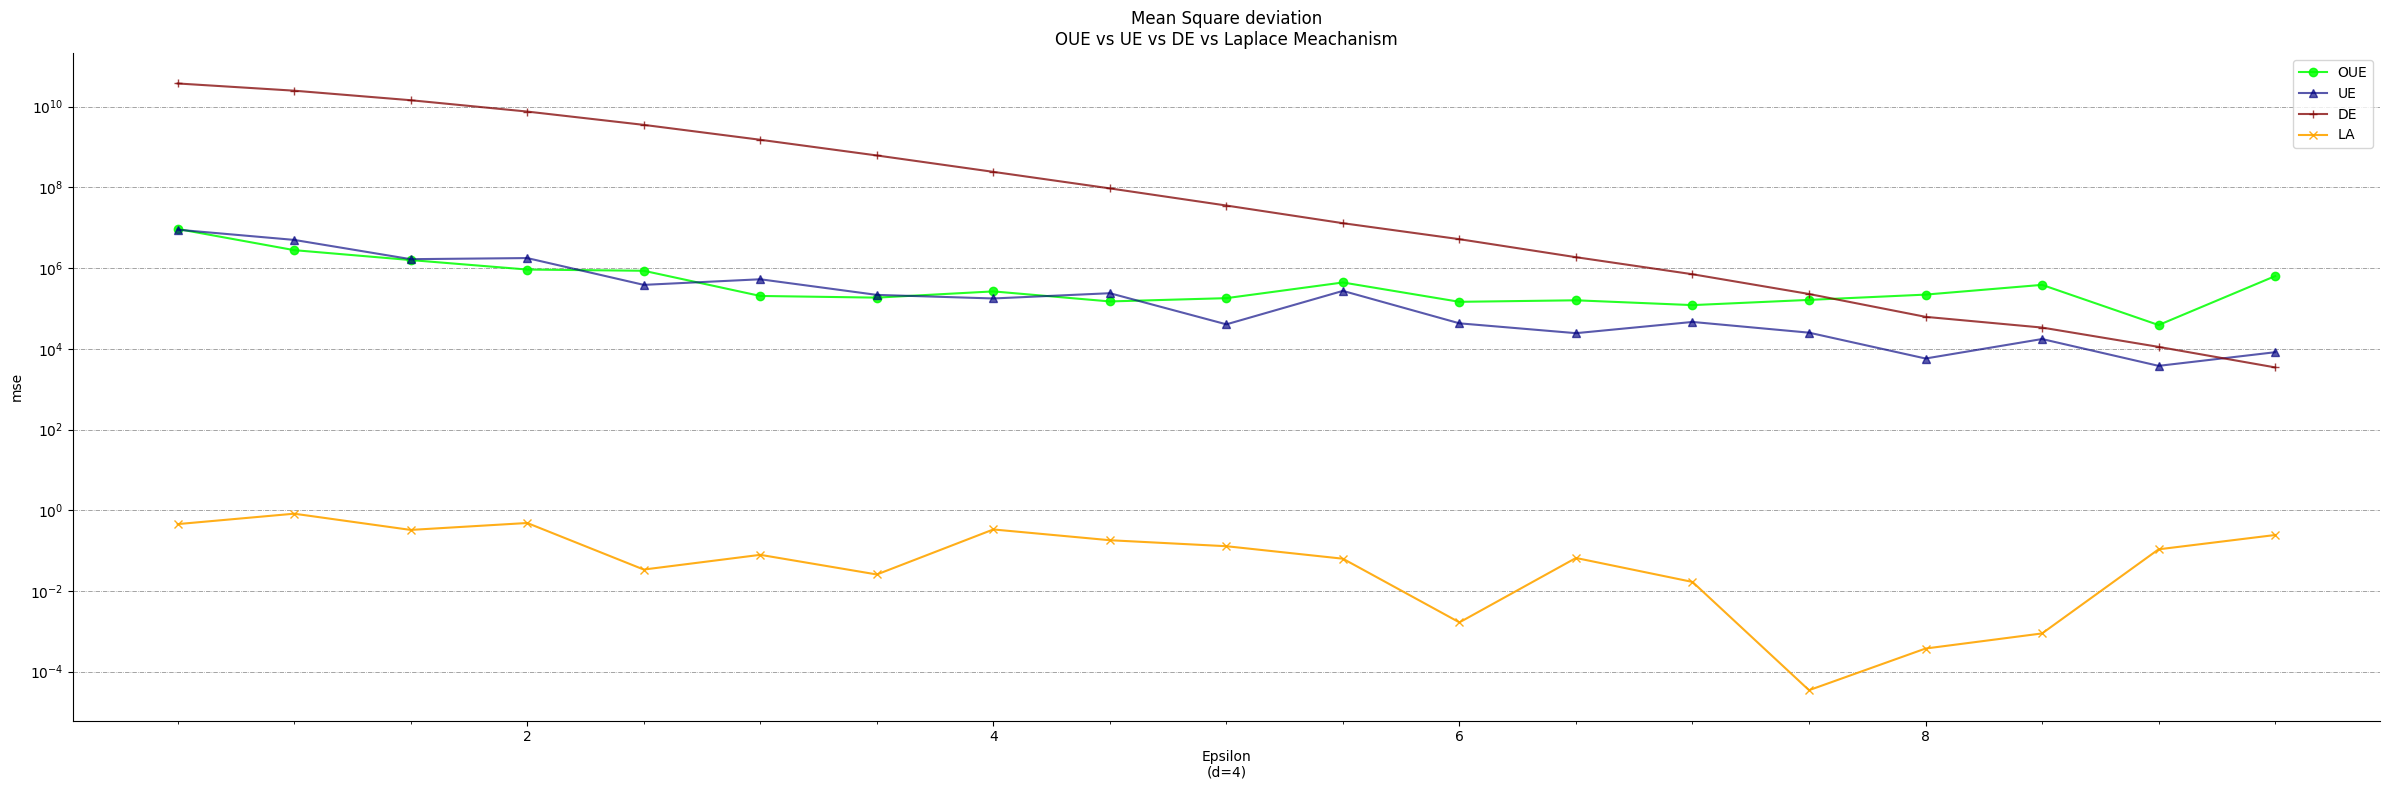

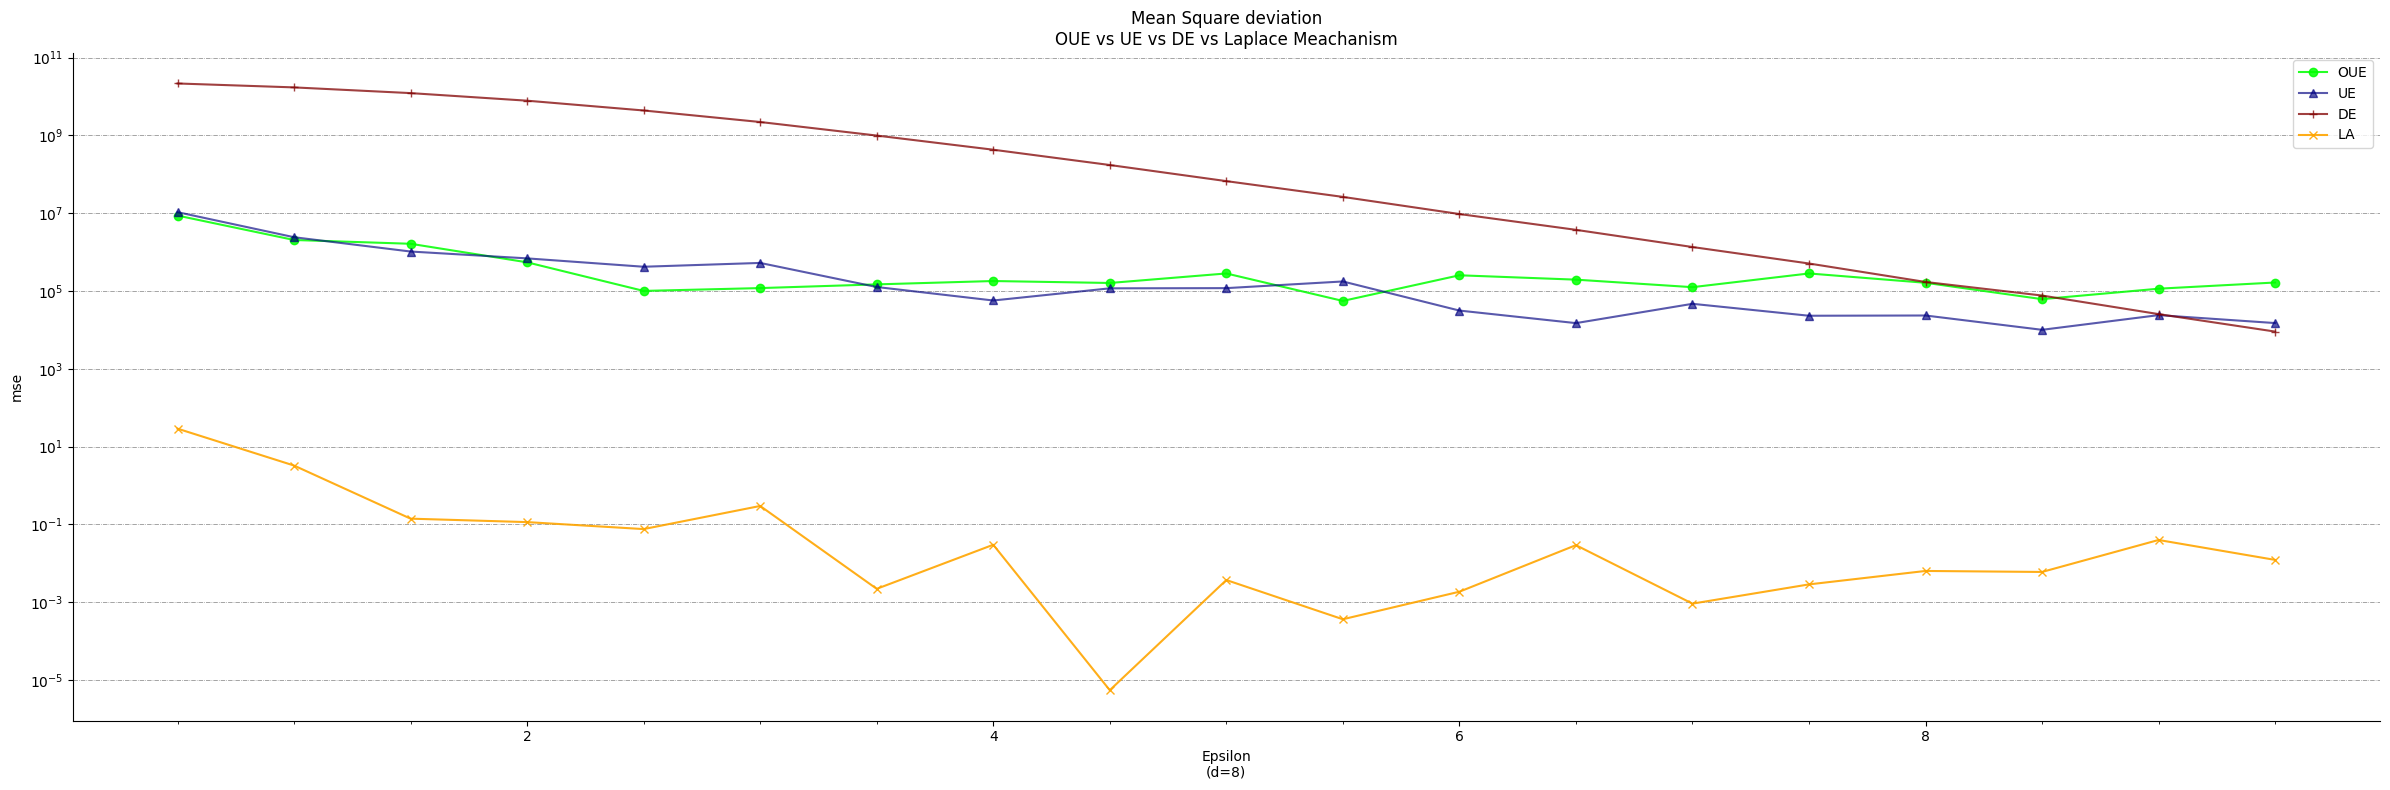

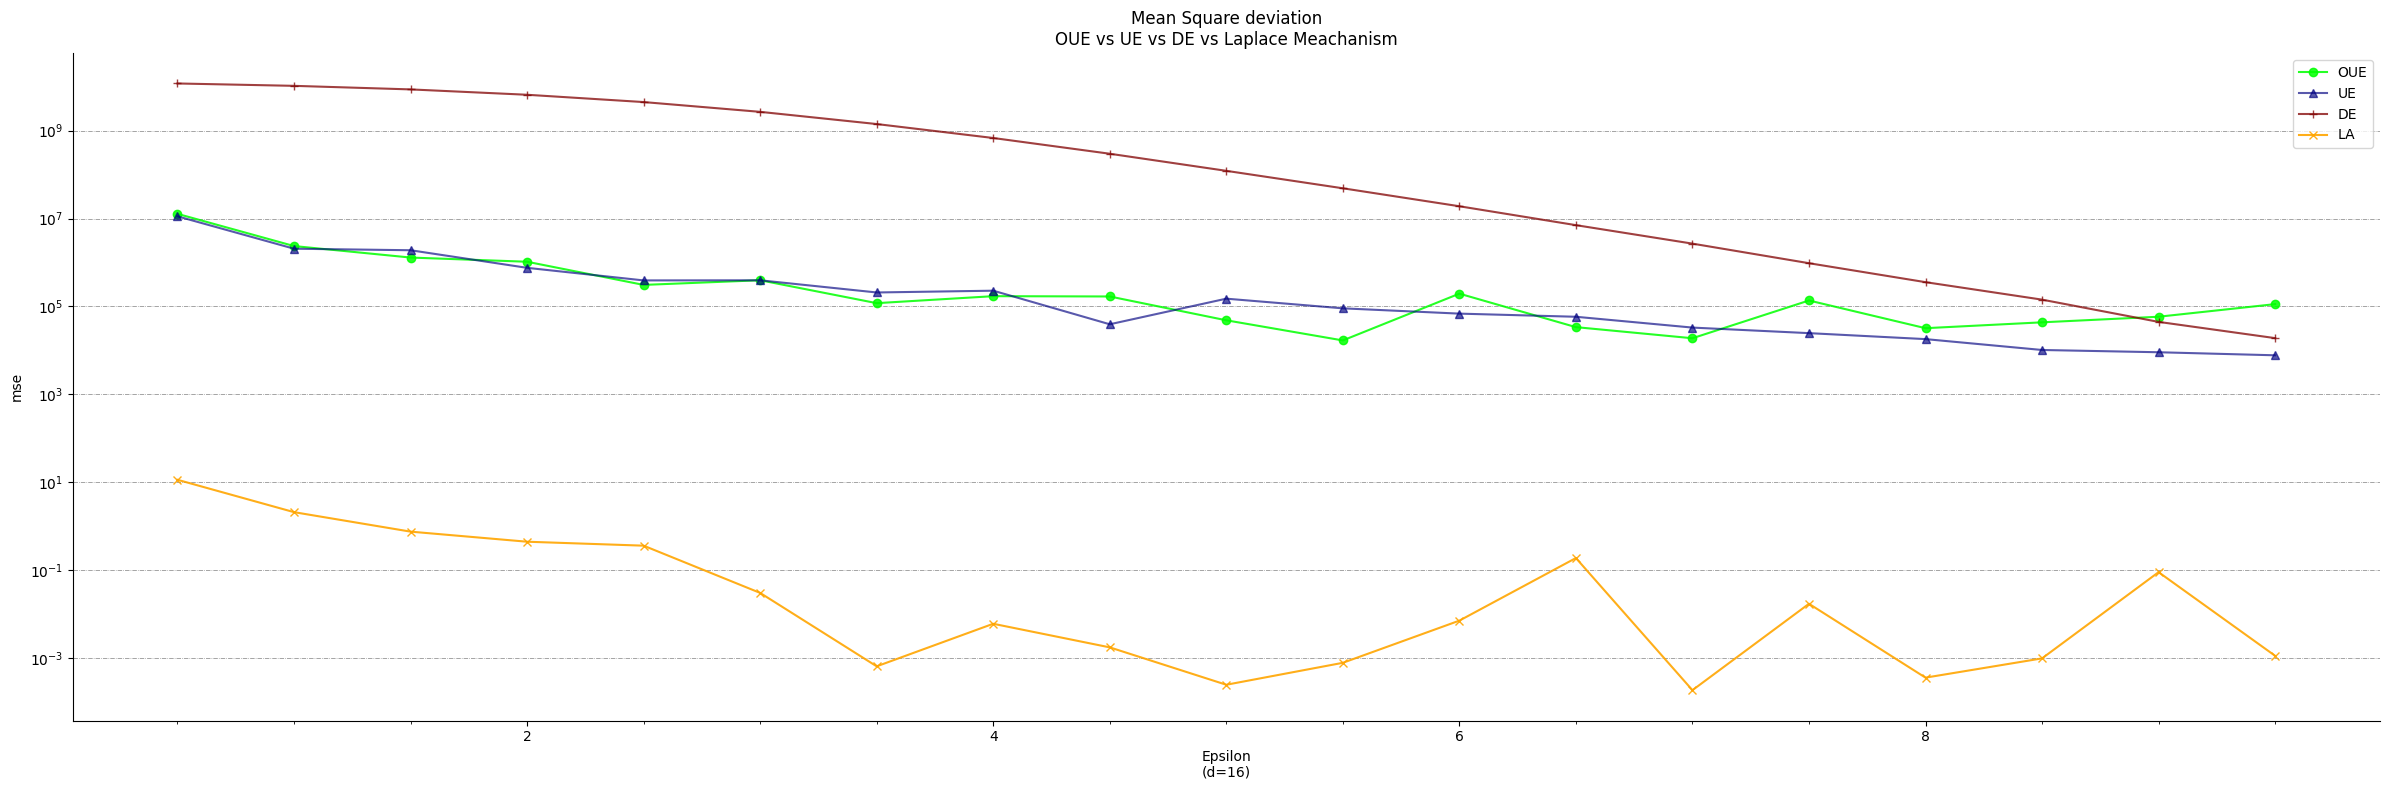

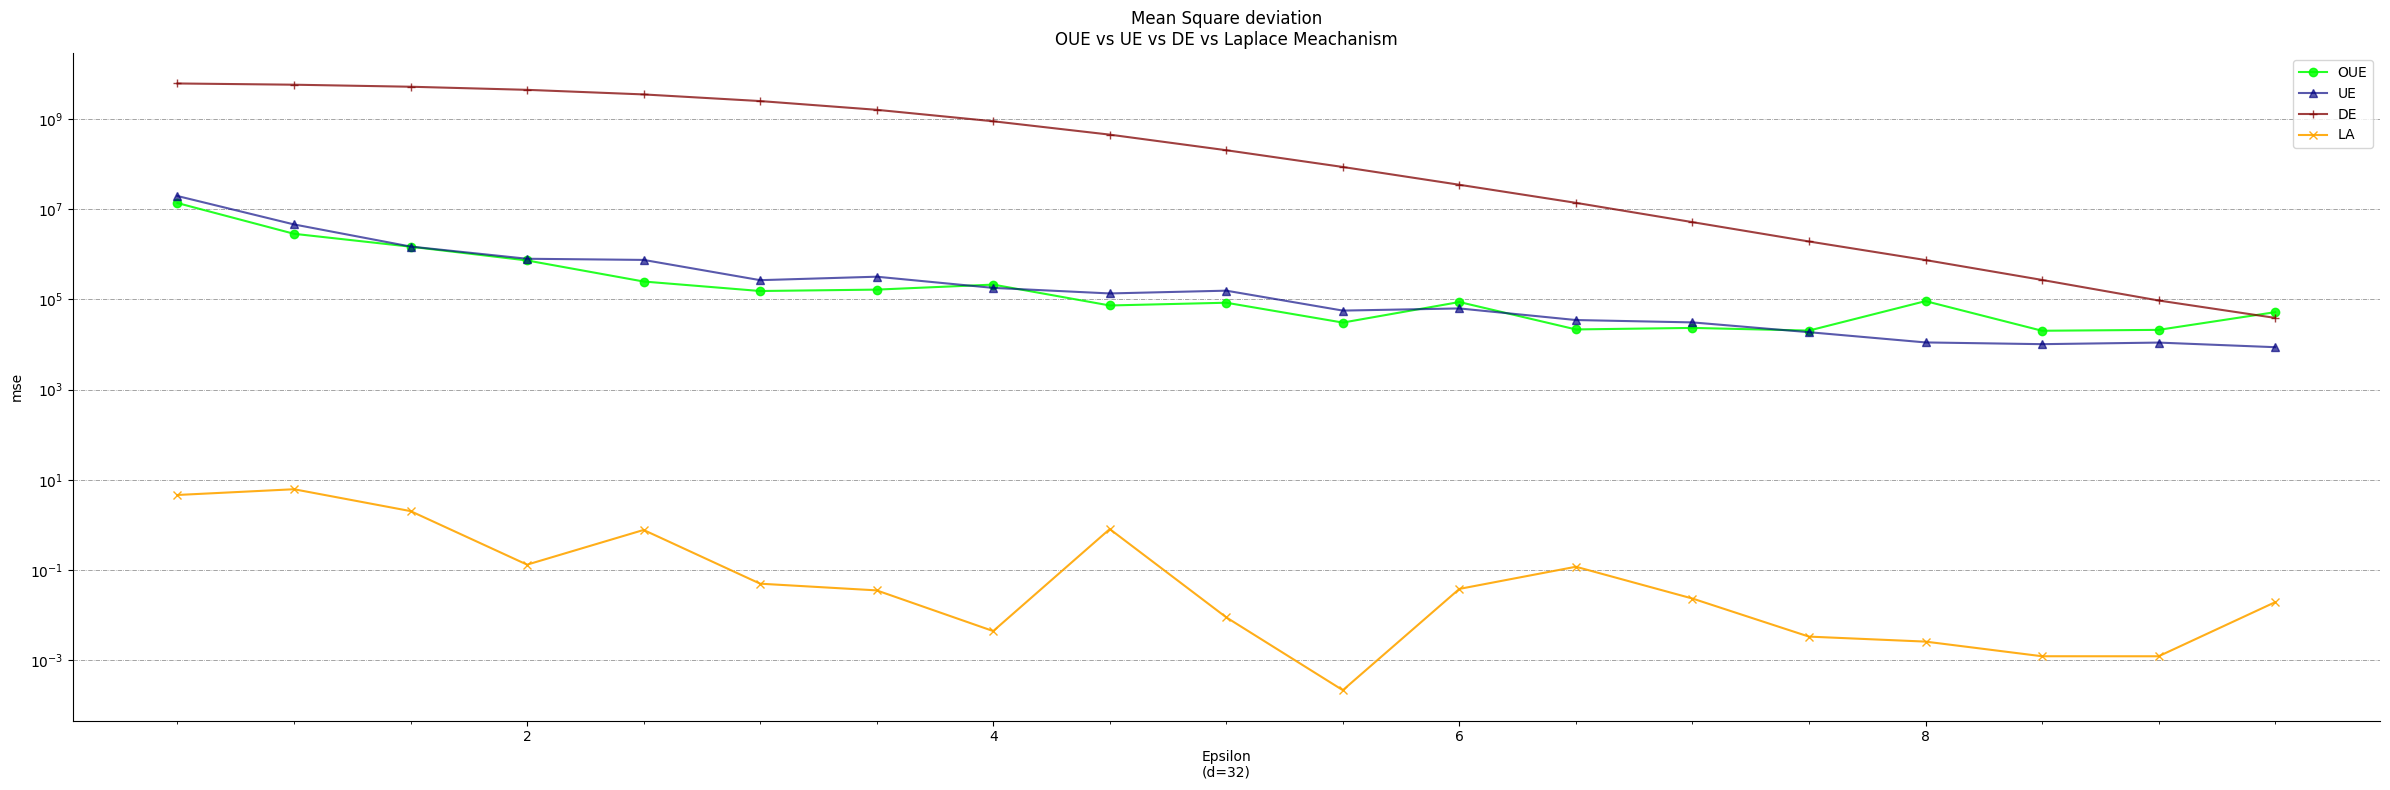

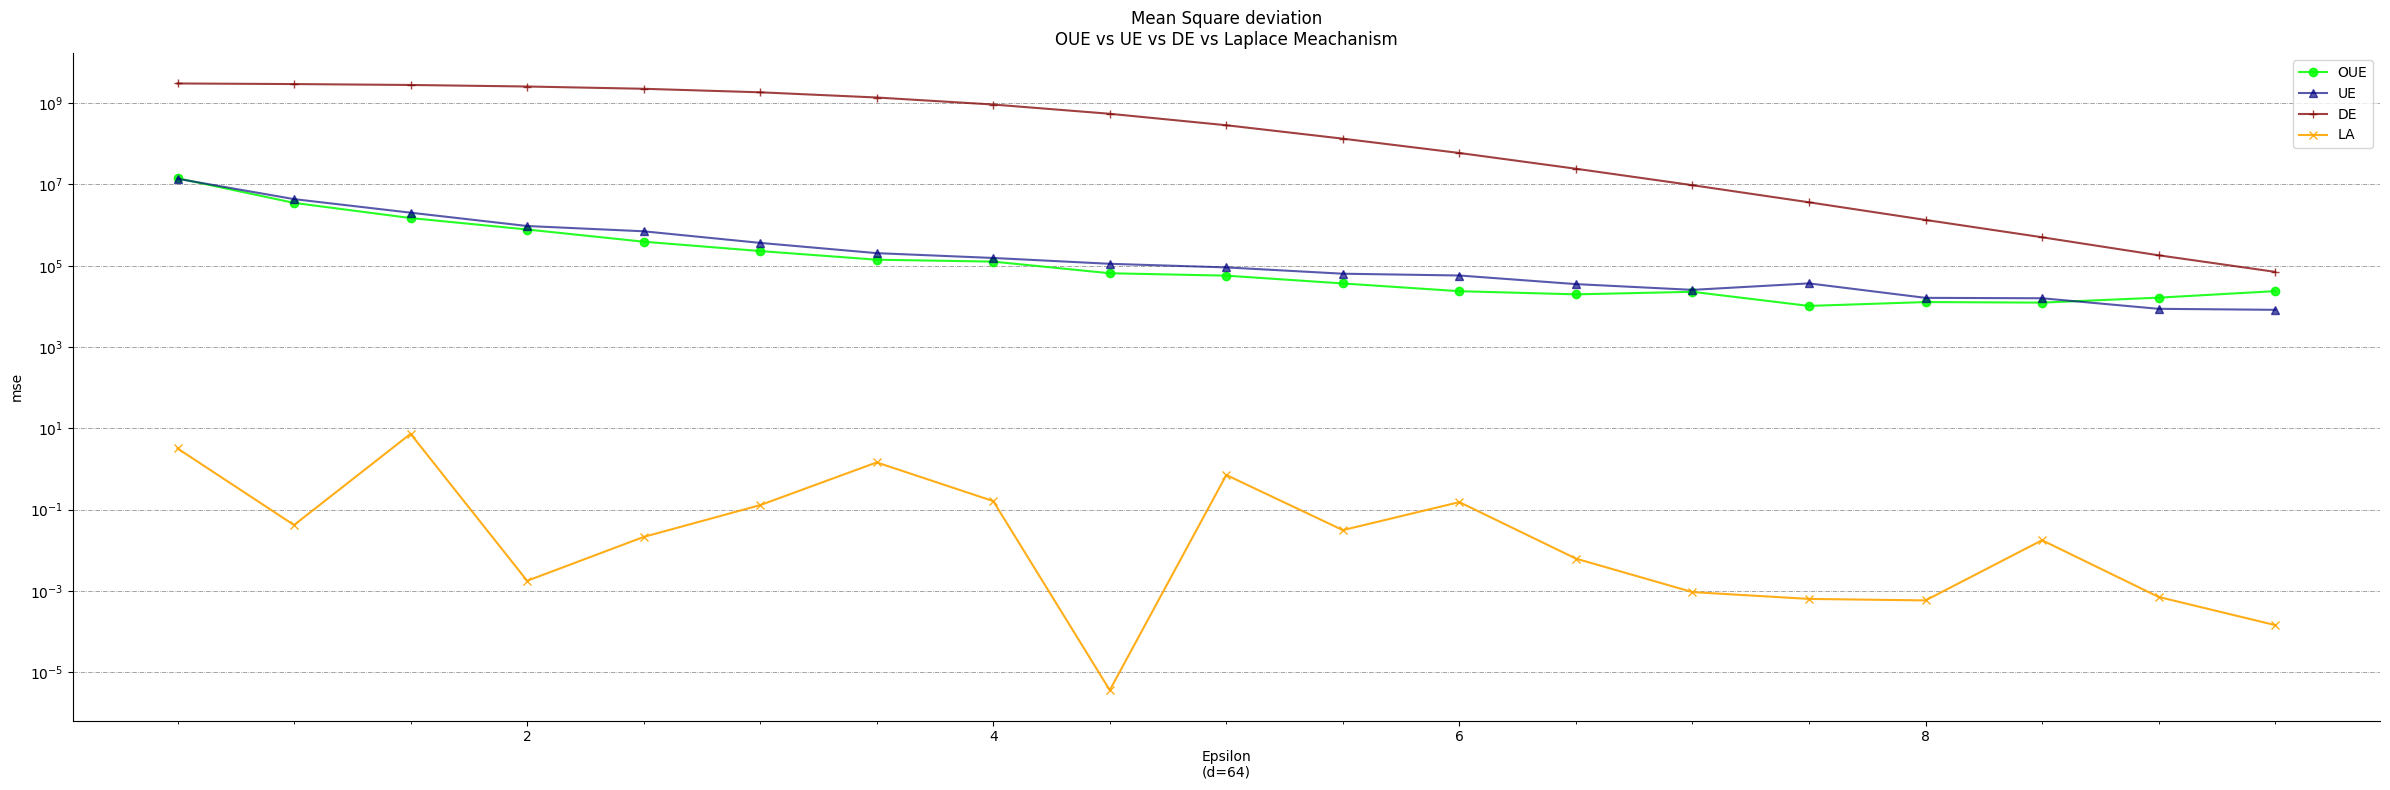

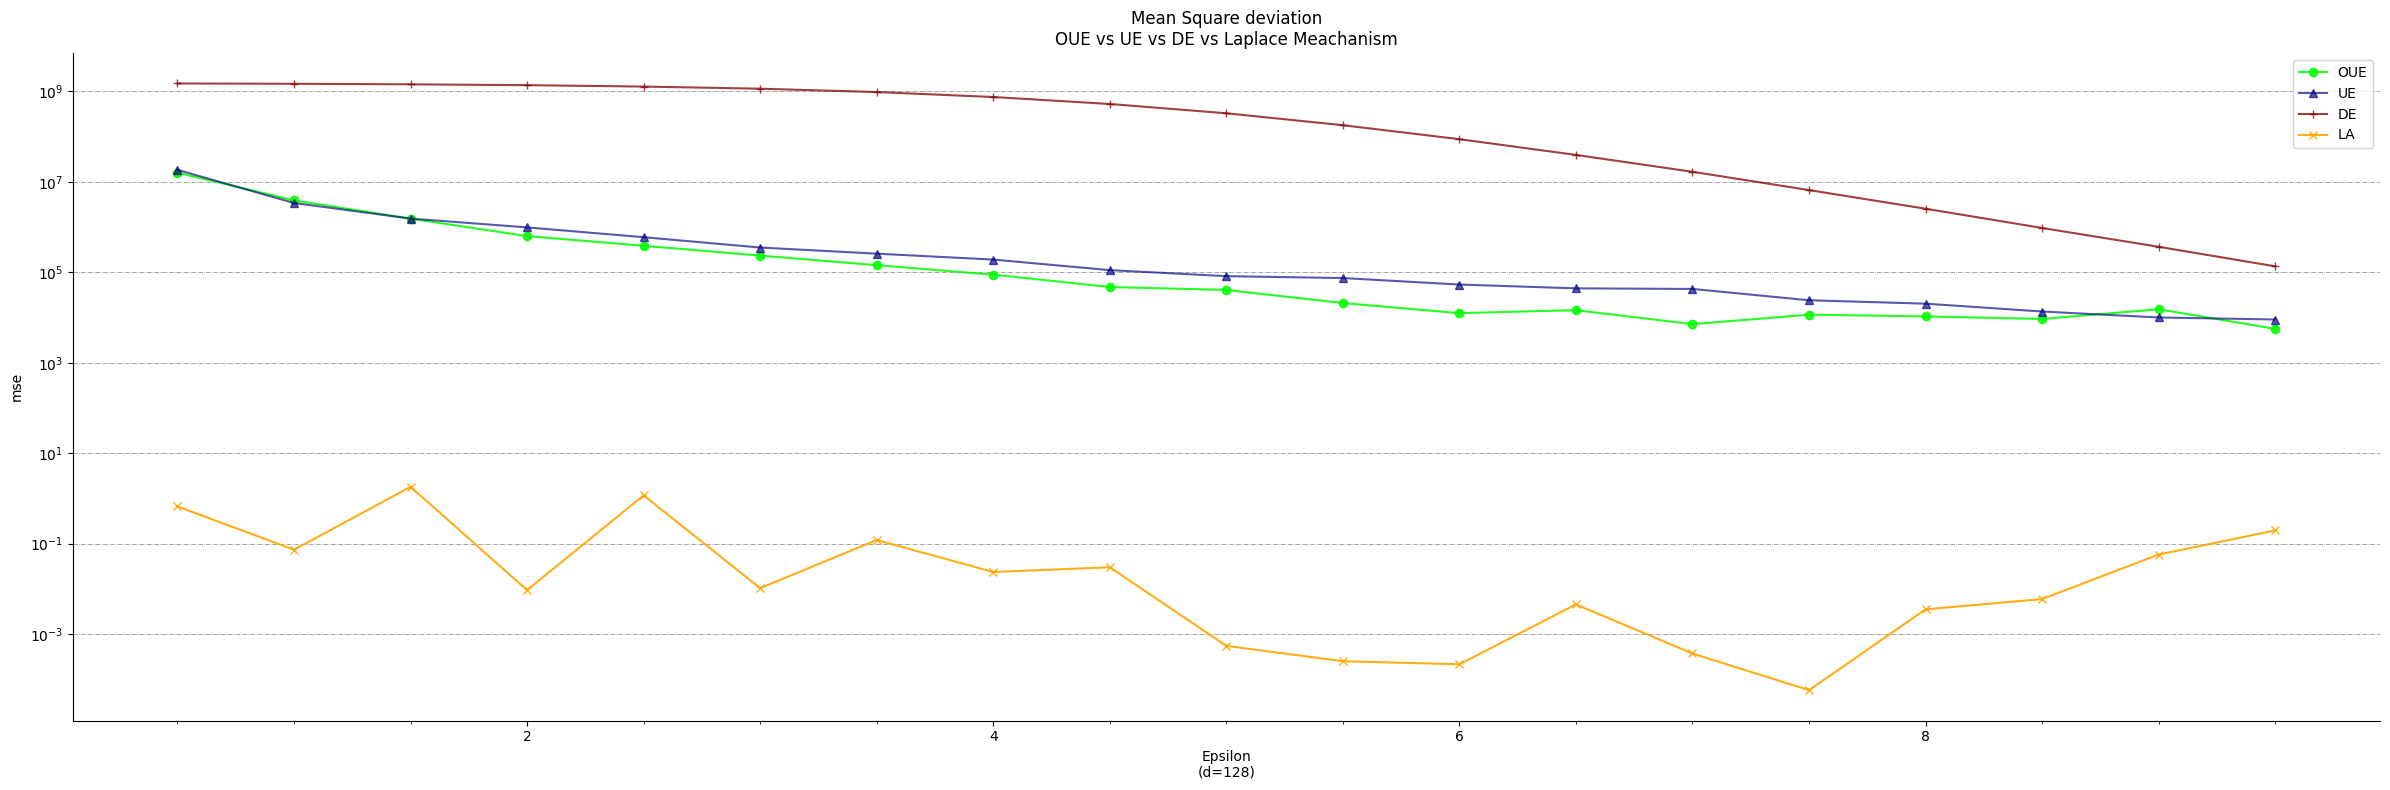

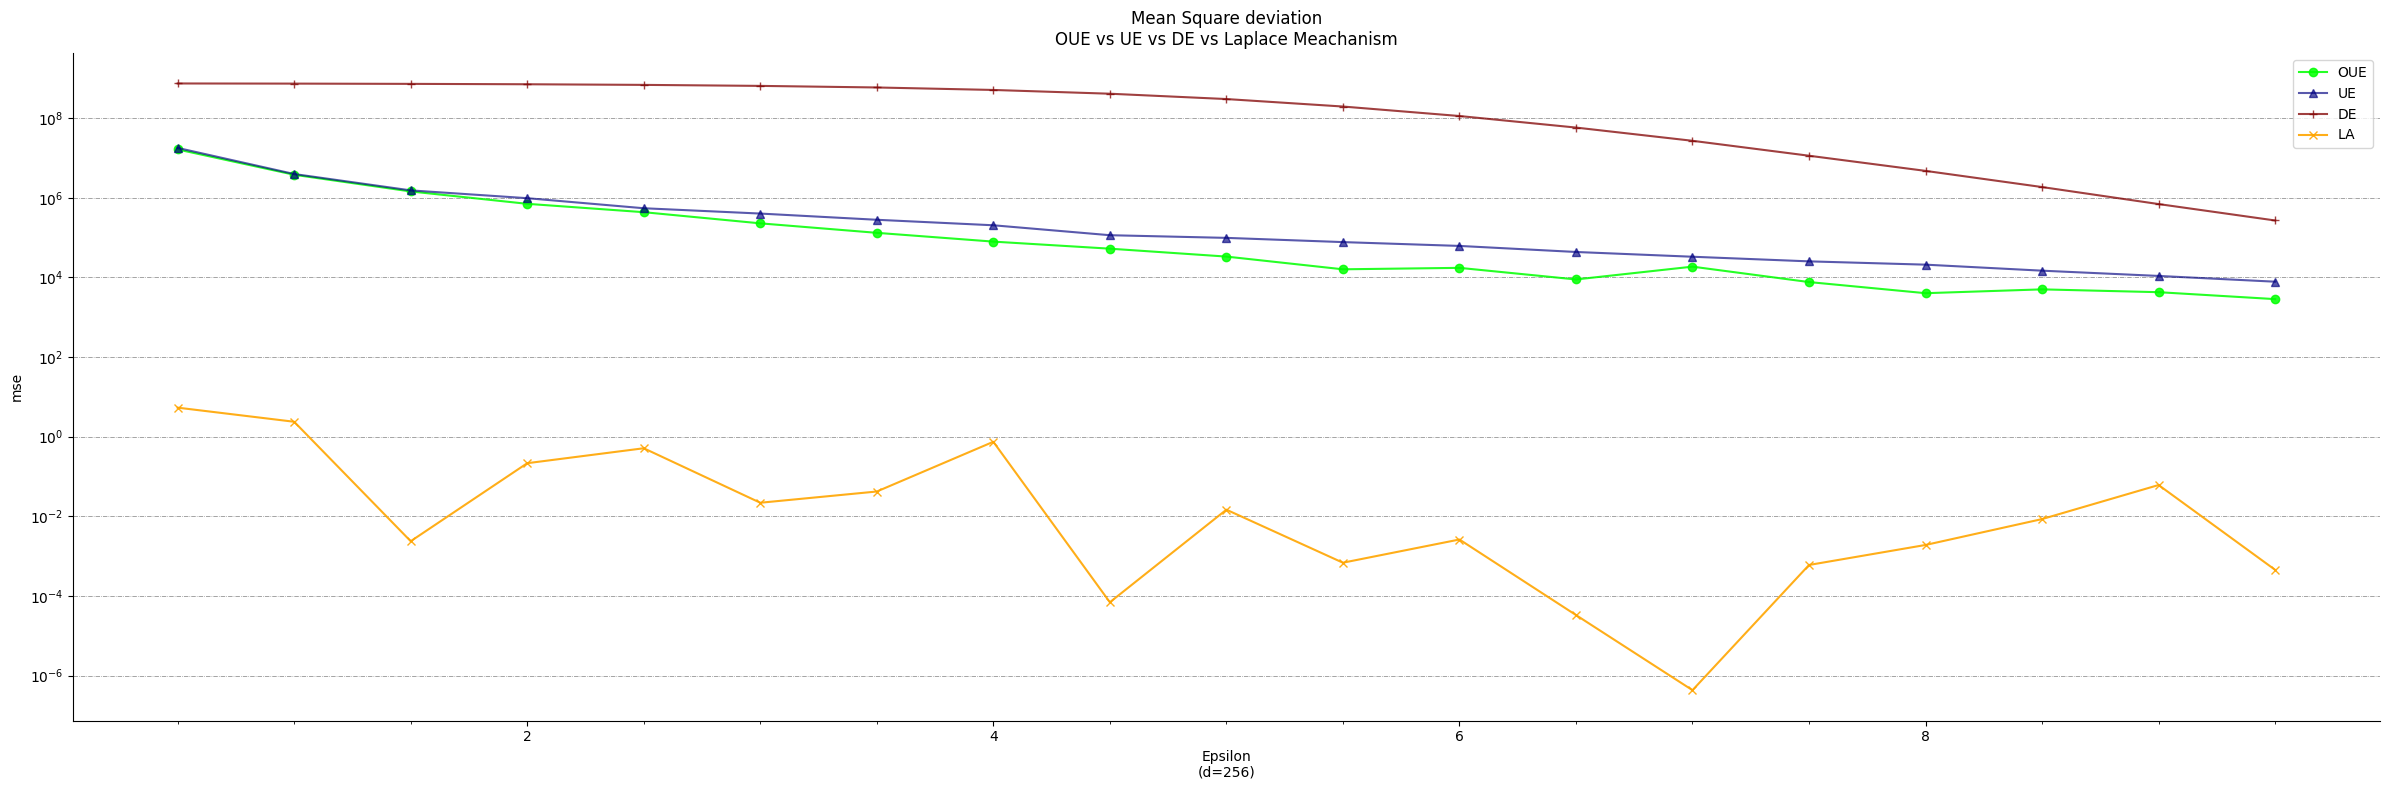

KeyboardInterrupt: 

In [27]:
for i in range(1,11):
    d = 2**i

    eRange = 10

    zipf_args = {
        'a': 1.5,
        'n': 10**6,
        'd': d
    }
    
    comparator2(zipf_me, eRange, **zipf_args)

### takes a bit 

In [ ]:
#meid(times, data_func, eRange, **kwargs)
#histo(d, epsilon_values, mse_valuesOUE, mse_valuesUE, mse_valuesDE)

epsilon_avg, mseOUE_avg, mseUE_avg, mseDE_avg = meid(10, normal_me, 10, **normal_args)
histo(4, epsilon_avg, mseOUE_avg, mseUE_avg, mseDE_avg)

In [ ]:
#meid(times, data_func, eRange, **kwargs)
#histo(d, epsilon_values, mse_valuesOUE, mse_valuesUE, mse_valuesDE)

epsilon_avg, mseOUE_avg, mseUE_avg, mseDE_avg = meid(10, zipf_me, 10, **zipf_args)
histo(4, epsilon_avg, mseOUE_avg, mseUE_avg, mseDE_avg)

In [ ]:
#meid(times, data_func, eRange, **kwargs)
#histo(d, epsilon_values, mse_valuesOUE, mse_valuesUE, mse_valuesDE)

epsilon_avg, mseOUE_avg, mseUE_avg, mseDE_avg = meid(10, normal_me, 10, **normal_args)
histo(20, epsilon_avg, mseOUE_avg, mseUE_avg, mseDE_avg)

In [ ]:
#meid(times, data_func, eRange, **kwargs)
#histo(d, epsilon_values, mse_valuesOUE, mse_valuesUE, mse_valuesDE)

epsilon_avg, mseOUE_avg, mseUE_avg, mseDE_avg = meid(10, zipf_me, 10, **zipf_args)
histo(20, epsilon_avg, mseOUE_avg, mseUE_avg, mseDE_avg)